In [1]:
from model_helpers import *

import cfgrib
import xarray as xr

import pandas as pd
import numpy as np

from pyPhenology import models, utils

from tqdm import trange, tqdm

import matplotlib.pyplot as plt

from warnings import warn
import warnings

warnings.filterwarnings('ignore')

high_cutoff_year = 2022
low_cutoff_year = 2010

In [264]:
def make_test_df(train_df):
    #print(train_df)
    species_sites = train_df['site_id'].unique()
        
    #print(species_sites)
    
    site_ripenesses = []

    for site in species_sites:
        site_df = train_df[train_df['site_id'] == site]

        site_ripenesses.append({
            'site_id': site,
            'doy': np.mean(site_df['doy'])
        })

    species_test_df = pd.DataFrame(site_ripenesses)
    species_test_df['year'] = high_cutoff_year
    
    species_test_df['formatted_sci_name'] = train_df['formatted_sci_name'].iloc[0]
    
    return species_test_df

# More specific to our uses.
def train_ripeness_small(observations, predictors, test_observations, test_predictors, model_name = 'ThermalTime'):

    print("running model {m}".format(m=model_name))
    Model = utils.load_model(model_name)
    model = Model()
    model.fit(observations, predictors, optimizer_params='practical')
    
    print(model)
    
    print("making predictions for model {m}".format(m=model_name))
    
    pred_list = []
    
    # assuming year is the same for both test obs and test preds
    for s in test_observations['site_id'].unique():
        site_obs = test_observations[test_observations['site_id'] == s]
        site_prediction = model.predict(site_obs, test_predictors)
        
        if len(site_prediction) > 0 and site_prediction[0] < 999:
            pred_list.append({
                'site_id': s,
                'formatted_sci_name': test_observations['formatted_sci_name'].iloc[0],
                'prediction': site_prediction[0],
                'doy': site_obs['doy'].iloc[0]
            })
        
    #print(pred_list)
    
    pred_df = pd.DataFrame.from_records(pred_list)
    
    #print(pred_df)
    
    preds = pred_df['prediction']
    test_days = pred_df['doy']
    sites = pred_df['site_id']

    if len(preds) == 0:
        print(test_observations)
        print(test_predictors)
    
    #print(pred_list)
   
    # Various error types
    model_mae = mae(test_days, preds)
    model_rmse = rmse(test_days, preds)
    median_error = np.median(np.abs(test_days - preds))

    print('model {m} got a MAE of {a}'.format(m=model_name,a=model_mae))
    print('model {m} got an RMSE of {a}'.format(m=model_name,a=model_rmse))
    print('model {m}\'s median error is: {a}'.format(m=model_name,a=median_error))

    print("Ripeness Day: {}".format(np.mean(preds)))
    
    #filtered_test_observations = test_observations[test_observations['site_id'].isin(sites)]
    
    ripeness_data = pred_df
    ripeness_data['ripeness_day'] = ripeness_data['prediction']
    
    ripeness_dict = {
        'model_object': model,
        'MAE': model_mae,
        'RMSE': model_rmse,
        'Median Error': median_error,
        'prediction_df': ripeness_data,
    }
    
    return ripeness_dict

Idea for corrections: take the lower error between the base error and the year-transformed error.


Best Approach is:
- High time resolution, correcting for missing data by using averaged data from previous years.
- Add European Weather data.
- No southern hemisphere. 
- Corrected error (i.e. date wrapping). 

Best reporting statistic: what portion of results lie under X.
For example, 80% of results lie under 1 STD, 95% lie under 2 STD. 
Can make a "confidence score" from this – percentile error? Ex. This is less error than 90% of things.  

In [100]:
# Load in high-res weather data
print("loading weather data")
grib_data = cfgrib.open_datasets('../data/monthly_weather_data.grib')

core_data = grib_data[0]

print("Loading Plant Data")
formatted_plants = pd.read_csv("../data/model_training_data/all_plants_formatted.csv", index_col=0)

formatted_plants['rounded_lat'] = np.round(formatted_plants['latitude'], 1)
formatted_plants['rounded_lon'] = np.round(formatted_plants['lon_360'], 1)

#rounded_sites = formatted_plants[['site_id', 'rounded_lat', 'rounded_lon']].drop_duplicates()

site_x_vals = xr.DataArray(formatted_plants['rounded_lat'], dims=['site'])
site_y_vals = xr.DataArray(formatted_plants['rounded_lon'], dims=['site'])

print("filtering weather data")
full_weather_data = core_data.sel(latitude=site_x_vals, longitude=site_y_vals, method='nearest').to_dataframe().dropna().drop_duplicates()

print("formatting weather data")
formatted_weather = format_weather_data(full_weather_data)

formatted_weather['latitude'] = np.round(formatted_weather['latitude'], 1)
formatted_weather['longitude'] = np.round(formatted_weather['longitude'], 1)

print("adding site IDs to weather data")
#rounded_sites['coordstring'] = rounded_sites['rounded_lat'].astype(str) + rounded_sites['rounded_lon'].astype(str)
formatted_plants['coordstring'] = formatted_plants['rounded_lat'].astype(str) + formatted_plants['rounded_lon'].astype(str)

formatted_weather['coordstring'] = formatted_weather['latitude'].astype(str) + formatted_weather['longitude'].astype(str)

formatted_plants['site_id'] = formatted_plants['coordstring'].str.replace(".", "")
formatted_weather['site_id'] = formatted_weather['coordstring'].str.replace(".", "")

## Add Site ID to the weather data
#weather_with_sites = pd.merge(formatted_weather, formatted_plants[['coordstring', 'site_id']], on='coordstring')#.drop('coordstring', axis=1)
## Separate into training data and testing data

# filter out current year
print("separating weather data")
formatted_weather = formatted_weather[formatted_weather['year'] != 2023]

# 
print("converting to Celsius")
formatted_weather['temperature'] = formatted_weather['temperature'] - 272.15

#weather_training = weather_with_sites[weather_with_sites['year'] < high_cutoff_year]
#weather_test = weather_with_sites[weather_with_sites['year'] >= high_cutoff_year]

# final formatting steps for plants
print("formatting plant data")
species_list = formatted_plants['formatted_sci_name'].unique()
formatted_plants.drop('species', axis=1, inplace=True)

# correct for missing sites
weather_sites = formatted_weather['site_id'].unique()

print("filtering plant data")
filtered_plants = formatted_plants[(formatted_plants['site_id'].isin(weather_sites)) & 
                                   (formatted_plants['year'] != 2023) &
                                   (formatted_plants['latitude'] > 0) &
                                    (formatted_plants['doy'] >= 60)]

aggressive_filtered_plants = filtered_plants.query('doy >= 145 and doy <= 314')


loading weather data
Loading Plant Data
filtering weather data
formatting weather data
formatting date columns
correcting leap years
adding site IDs to weather data
separating weather data
converting to Celsius
formatting plant data
filtering plant data


In [73]:
euro_data = load_euro_weather_data(euro_path, '../data/high_res_euro_stations.csv')

In [74]:
## Make site ID column of euro data from coordstring

print("constructing european site IDs")
euro_data['site_id'] = euro_data['coordstring'].str.replace(".", "")

# Make sure to drop duplicate sites/coordstrings?
print("filtering euro data")
filtered_euro = euro_data[euro_data['site_id'].isin(formatted_weather['site_id'].unique())]

# merge euro data with monthly 

constructing european site IDs
filtering euro data


In [77]:
euro_sites = euro_data['site_id'].unique()

unmutual_sites = formatted_weather[~formatted_weather['site_id'].isin(euro_sites)]

Problem is with the merge on mutual sites. 

In [332]:
## STATS

# get confidence intervals for species

def calc_confidence_interval():
    pass

def score_model(prediction_df):
    observed = prediction_df['doy']
    predicted = prediction_df['ripeness_day']
    
    n_species = prediction_df['formatted_sci_name'].nunique()
    
    print("Number of Species:", n_species)
    
    median_err = np.round(np.median(prediction_df['abs_error']), 2)
    std = np.round(np.std(prediction_df['abs_error']), 2)
    
    # MAE, RMSE, median
    
    print("Error metrics:")
    print("MAE:", np.round(mae(observed, predicted), 2))
    print("RMSE:", np.round(rmse(observed, predicted), 2))
    print("Median Absolute Error:", np.round(median_err, 2))
    
    # portion of errors under the SD
    print("SD portion (SD = {})".format(std))
    print(np.round(len(prediction_df.query('abs_error < {}'.format(std))) / len(prediction_df), 2))
    
    print("Month threshold:")
    print(np.round(len(prediction_df.query('abs_error < 30')) / len(prediction_df), 2))

    # 
    print("2 * SD portion (2SD = {})".format(2 * std))
    print(np.round(len(prediction_df.query('abs_error < {}'.format(2 * std))) / len(prediction_df), 2))
    

# get how "good" one sample is compared to the whole sample
def calc_error_percentile(sample, full_sample):
    sample_median = np.median(sample['abs_error'])
    
    print(sample_median)
    print(1 - len(full_sample.query('abs_error < {}'.format(sample_median))) / len(full_sample))

In [289]:
def train_species_models(full_plant_data, full_weather_data, train_threshold=10, test_threshold=1, save_dir='trained_models'):
    # Separate weather data into train and test
    weather_training = full_weather_data[full_weather_data['year'] < high_cutoff_year]
    weather_test = full_weather_data[full_weather_data['year'] >= high_cutoff_year]
    
    species_prediction_dict = {}
    species_list = full_plant_data['formatted_sci_name'].unique()
    print(species_list)

    for s in tqdm(species_list):
        print("\n\n", s)
        species_train_df = full_plant_data.query('formatted_sci_name == "{}" and year < {}'.format(s, high_cutoff_year))
        
        #print(species_train_df)
        if len(species_train_df) < train_threshold:
            print("not enough training data")
            continue        

        species_test_df = full_plant_data.query('formatted_sci_name == "{}" and year >= {}'.format(s, high_cutoff_year))

        if len(species_test_df) < test_threshold:
            print("Not enough test data for {}, interpolating".format(s))
            # make predictions and compare to the mean ripeness day at each site
            species_test_df = make_test_df(full_plant_data)

        if len(species_test_df) == 0:
            print("No test data for {}, after attempt at rectification".format(s))
            #print(species_test_df)
        
        if len(weather_test) == 0:
            print("No weather data")
            continue
            
        filtered_weather_test = weather_test[weather_test['site_id'].isin(species_test_df['site_id'])]
        filtered_species_test = species_test_df[species_test_df['site_id'].isin(filtered_weather_test['site_id'])]
        
        #print(species_train_df, weather_training)
        #print(species_test_df)
        #print(filtered_weather_test)
        #print(np.sort(filtered_species_test['site_id'].unique()))
        #print(np.sort(filtered_weather_test['site_id'].unique()))
        
        model, predictions = train_ripeness_small(species_train_df, weather_training,
                            filtered_species_test, filtered_weather_test)
        
        save_model 

        #break
        
        species_prediction_dict[s] = predictions
    
    #print(species_prediction_dict)
        
    # gets a list of all the prediction dataframes from the species model
    df_list = [i['prediction_df'] for i in species_prediction_dict.values()]

    full_prediction_df = pd.concat(df_list)

    full_prediction_df['abs_error'] = np.abs(full_prediction_df['doy'] - full_prediction_df['ripeness_day'])
    
    #print(score_model(full_prediction_df))
    
    return full_prediction_df


In [190]:
euro_observations = filtered_plants[filtered_plants['site_id'].isin(filtered_euro['site_id'])]


In [279]:
normal_training_euro = train_species_models(euro_observations, filtered_euro)

['Ficus' 'Olea europea' 'Rubus' 'Citrus sinensis' 'Prunus domestica'
 'Prunus cerasifera' 'Prunus' 'Malus domestica' 'Malus' 'Malus pumila'
 'Juglans' 'Prunus avium' 'Cornus mas' 'Prunus cerasus' 'Pyrus communis'
 'Pyrus']


  0%|                                                                                                                                                                              | 0/16 [00:00<?, ?it/s]



 Ficus
not enough training data


 Olea europea
not enough training data


 Rubus
not enough training data


 Citrus sinensis
not enough training data


 Prunus domestica
No test data for Prunus domestica
running model ThermalTime


 31%|███████████████████████████████████████████████████▉                                                                                                                  | 5/16 [00:02<00:06,  1.76it/s]

making predictions for model ThermalTime
  site_id formatted_sci_name  prediction         doy
0  466145   Prunus domestica         238  255.833333
1  482165   Prunus domestica         232  225.000000
2  486150   Prunus domestica         235  265.000000
3  482164   Prunus domestica         231  235.785714
4   50331   Prunus domestica         232  222.000000
model ThermalTime got a MAE of 13.923809523809524
model ThermalTime got an RMSE of 16.672917195273705
model ThermalTime's median error is: 10.0
Ripeness Day: 233.6


 Prunus cerasifera
not enough training data


 Prunus
No test data for Prunus
running model ThermalTime


 44%|████████████████████████████████████████████████████████████████████████▋                                                                                             | 7/16 [00:06<00:08,  1.01it/s]

making predictions for model ThermalTime
  site_id formatted_sci_name  prediction    doy
0  524133             Prunus         178  190.0
1  544185             Prunus         215  234.0
2   49472             Prunus         200  188.6
model ThermalTime got a MAE of 14.133333333333335
model ThermalTime got an RMSE of 14.548310325715953
model ThermalTime's median error is: 12.0
Ripeness Day: 197.66666666666666


 Malus domestica
No test data for Malus domestica
running model ThermalTime
making predictions for model ThermalTime


 50%|███████████████████████████████████████████████████████████████████████████████████                                                                                   | 8/16 [00:30<00:46,  5.84s/it]

    site_id formatted_sci_name  prediction         doy
0    475152    Malus domestica         248  285.500000
1    482164    Malus domestica         245  236.333333
2     49285    Malus domestica         246  266.444444
3     50185    Malus domestica         246  241.400000
4     50084    Malus domestica         245  273.285714
..      ...                ...         ...         ...
122  511146    Malus domestica         248  277.000000
123  475160    Malus domestica         248  274.000000
124   42331    Malus domestica         244  247.000000
125   41316    Malus domestica         244  168.500000
126   42021    Malus domestica         246  243.000000

[127 rows x 4 columns]
model ThermalTime got a MAE of 13.532275618576538
model ThermalTime got an RMSE of 18.350329350612558
model ThermalTime's median error is: 9.583333333333343
Ripeness Day: 246.93700787401573


 Malus
not enough training data


 Malus pumila
not enough training data


 Juglans
not enough training data


 Prunus avium

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 12/16 [01:01<00:27,  6.77s/it]

   site_id formatted_sci_name  prediction         doy
0   482164       Prunus avium         161  162.555556
1   475152       Prunus avium         173  152.000000
2   475160       Prunus avium         171  194.333333
3   466145       Prunus avium         171  173.000000
4   486150       Prunus avium         168  191.000000
..     ...                ...         ...         ...
94  543131       Prunus avium         175  191.500000
95  480122       Prunus avium         168  171.000000
96  511146       Prunus avium         167  177.000000
97   49662       Prunus avium         169  153.000000
98   49472       Prunus avium         170  187.000000

[99 rows x 4 columns]
model ThermalTime got a MAE of 10.030654306411883
model ThermalTime got an RMSE of 12.42331448819813
model ThermalTime's median error is: 9.0
Ripeness Day: 169.5050505050505


 Cornus mas
not enough training data


 Prunus cerasus
not enough training data


 Pyrus communis
No test data for Pyrus communis
running model ThermalTi

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [01:14<00:00,  4.64s/it]

   site_id formatted_sci_name  prediction         doy
0    49285     Pyrus communis         254  251.666667
1    50084     Pyrus communis         254  259.666667
2    50185     Pyrus communis         254  240.000000
3    54196     Pyrus communis         255  255.666667
4    50281     Pyrus communis         254  263.750000
..     ...                ...         ...         ...
91   49283     Pyrus communis         254  242.500000
92  512123     Pyrus communis         254  274.666667
93   49676     Pyrus communis         254  256.600000
94  494204     Pyrus communis         254  258.666667
95  531231     Pyrus communis         281  250.000000

[96 rows x 4 columns]
model ThermalTime got a MAE of 13.775679788961043
model ThermalTime got an RMSE of 17.064499959563843
model ThermalTime's median error is: 12.041666666666657
Ripeness Day: 254.73958333333334


 Pyrus
not enough training data


In [280]:
# this doesn't improve things that much – same number of species
#normal_training_euro_low_thresh = train_species_models(euro_observations, filtered_euro, 5)

['Ficus' 'Olea europea' 'Rubus' 'Citrus sinensis' 'Prunus domestica'
 'Prunus cerasifera' 'Prunus' 'Malus domestica' 'Malus' 'Malus pumila'
 'Juglans' 'Prunus avium' 'Cornus mas' 'Prunus cerasus' 'Pyrus communis'
 'Pyrus']


  0%|                                                                                                                                                                              | 0/16 [00:00<?, ?it/s]



 Ficus
not enough training data


 Olea europea
not enough training data


 Rubus
not enough training data


 Citrus sinensis
not enough training data


 Prunus domestica
No test data for Prunus domestica
running model ThermalTime


 31%|███████████████████████████████████████████████████▉                                                                                                                  | 5/16 [00:04<00:09,  1.19it/s]

making predictions for model ThermalTime
  site_id formatted_sci_name  prediction         doy
0  466145   Prunus domestica         232  255.833333
1  482165   Prunus domestica         232  225.000000
2  486150   Prunus domestica         232  265.000000
3  482164   Prunus domestica         232  235.785714
4   50331   Prunus domestica         232  222.000000
model ThermalTime got a MAE of 15.523809523809524
model ThermalTime got an RMSE of 19.08066775786864
model ThermalTime's median error is: 10.0
Ripeness Day: 232.0


 Prunus cerasifera
not enough training data


 Prunus
No test data for Prunus
running model ThermalTime


 44%|████████████████████████████████████████████████████████████████████████▋                                                                                             | 7/16 [00:08<00:11,  1.26s/it]

making predictions for model ThermalTime
  site_id formatted_sci_name  prediction    doy
0  524133             Prunus         178  190.0
1  544185             Prunus         215  234.0
2   49472             Prunus         200  188.6
model ThermalTime got a MAE of 14.133333333333335
model ThermalTime got an RMSE of 14.548310325715953
model ThermalTime's median error is: 12.0
Ripeness Day: 197.66666666666666


 Malus domestica
No test data for Malus domestica
running model ThermalTime
making predictions for model ThermalTime


 50%|███████████████████████████████████████████████████████████████████████████████████                                                                                   | 8/16 [00:35<00:53,  6.67s/it]

    site_id formatted_sci_name  prediction         doy
0    475152    Malus domestica         248  285.500000
1    482164    Malus domestica         245  236.333333
2     49285    Malus domestica         246  266.444444
3     50185    Malus domestica         246  241.400000
4     50084    Malus domestica         245  273.285714
..      ...                ...         ...         ...
122  511146    Malus domestica         248  277.000000
123  475160    Malus domestica         248  274.000000
124   42331    Malus domestica         244  247.000000
125   41316    Malus domestica         244  168.500000
126   42021    Malus domestica         246  243.000000

[127 rows x 4 columns]
model ThermalTime got a MAE of 13.54014963432457
model ThermalTime got an RMSE of 18.349443278026524
model ThermalTime's median error is: 9.583333333333343
Ripeness Day: 246.96062992125985


 Malus
not enough training data


 Malus pumila
not enough training data


 Juglans
not enough training data


 Prunus avium


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 12/16 [01:00<00:25,  6.43s/it]

   site_id formatted_sci_name  prediction         doy
0   482164       Prunus avium         163  162.555556
1   475152       Prunus avium         173  152.000000
2   475160       Prunus avium         172  194.333333
3   466145       Prunus avium         171  173.000000
4   486150       Prunus avium         169  191.000000
..     ...                ...         ...         ...
94  543131       Prunus avium         173  191.500000
95  480122       Prunus avium         168  171.000000
96  511146       Prunus avium         168  177.000000
97   49662       Prunus avium         170  153.000000
98   49472       Prunus avium         171  187.000000

[99 rows x 4 columns]
model ThermalTime got a MAE of 9.85420729663154
model ThermalTime got an RMSE of 12.240198777303902
model ThermalTime's median error is: 8.166666666666657
Ripeness Day: 169.7979797979798


 Cornus mas
not enough training data


 Prunus cerasus
not enough training data


 Pyrus communis
No test data for Pyrus communis
running mo

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [01:18<00:00,  4.91s/it]

   site_id formatted_sci_name  prediction         doy
0    49285     Pyrus communis         255  251.666667
1    50084     Pyrus communis         255  259.666667
2    50185     Pyrus communis         255  240.000000
3    54196     Pyrus communis         255  255.666667
4    50281     Pyrus communis         255  263.750000
..     ...                ...         ...         ...
91   49283     Pyrus communis         255  242.500000
92  512123     Pyrus communis         255  274.666667
93   49676     Pyrus communis         255  256.600000
94  494204     Pyrus communis         255  258.666667
95  531231     Pyrus communis         279  250.000000

[96 rows x 4 columns]
model ThermalTime got a MAE of 13.671513122294376
model ThermalTime got an RMSE of 16.97429579843118
model ThermalTime's median error is: 12.083333333333343
Ripeness Day: 255.28125


 Pyrus
not enough training data


In [251]:
normal_training = train_species_models(filtered_plants, formatted_weather)

['Rubus' 'Rubus occidentalis' 'Ficus' 'Ficus carica' 'Ficus citrifolia'
 'Ficus macrophylla' 'Ficus sycomorus' 'Olea europaea' 'Olea europea'
 'Olea' 'Morus rubra' 'Morus nigra' 'Morus' 'Morus alba' 'Morus macroura'
 'Morus australis' 'Amelanchier alnifolia' 'Amelanchier arborea'
 'Amelanchier canadensis' 'Amelanchier grandiflora' 'Amelanchier laevis'
 'Amelanchier utahensis' 'Amelanchier' 'Citrus' 'Citrus jambhiri'
 'Citrus limon' 'Rubus idaeus' 'Rubus ellipticus' 'Rubus hayata'
 'Rubus odoratus' 'Rubus phoenicolasius' 'Rubus rolfei' 'Citrus aurantium'
 'Citrus sinensis' 'Prunus americana' 'Prunus domestica' 'Prunus maritima'
 'Prunus nigra' 'Prunus cerasifera' 'Prunus' 'Prunus angustifolia'
 'Prunus cocomilia' 'Prunus salicina' 'Prunus subcordata'
 'Prunus mexicana' 'Prunus rivularis' 'Eriobotrya japonica'
 'Malus sieboldii' 'Malus' 'Malus pumila' 'Malus domestica'
 'Malus sylvestris' 'Malus coronaria' "Malus '" 'Malus sieversii'
 'Malus baccata' 'Malus ioensis' 'Malus hupehensis' 'M

  0%|                                                                                                                                                                              | 0/95 [00:00<?, ?it/s]



 Rubus
running model ThermalTime
making predictions for model ThermalTime
model ThermalTime got a MAE of 24.5
model ThermalTime got an RMSE of 41.125823193382196
model ThermalTime's median error is: 10.0
Ripeness Day: 183.0


  1%|█▋                                                                                                                                                                    | 1/95 [00:01<02:19,  1.48s/it]



 Rubus occidentalis
running model ThermalTime


  2%|███▍                                                                                                                                                                  | 2/95 [00:04<04:08,  2.68s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 10.6
model ThermalTime got an RMSE of 13.733171520082315
model ThermalTime's median error is: 6.0
Ripeness Day: 189.2


 Ficus
running model ThermalTime


  3%|█████▏                                                                                                                                                                | 3/95 [00:07<03:39,  2.39s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 21.5
model ThermalTime got an RMSE of 26.602631448787168
model ThermalTime's median error is: 17.0
Ripeness Day: 245.0


 Ficus carica
running model ThermalTime


  4%|██████▉                                                                                                                                                               | 4/95 [00:08<03:12,  2.11s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 29.22222222222222
model ThermalTime got an RMSE of 40.94847711182649
model ThermalTime's median error is: 13.0
Ripeness Day: 251.66666666666666


 Ficus citrifolia
not enough training data


 Ficus macrophylla
not enough training data


 Ficus sycomorus
not enough training data


 Olea europaea
running model ThermalTime


  8%|█████████████▉                                                                                                                                                        | 8/95 [00:10<01:16,  1.14it/s]

making predictions for model ThermalTime
model ThermalTime got a MAE of 77.66666666666667
model ThermalTime got an RMSE of 92.0869154657707
model ThermalTime's median error is: 55.0
Ripeness Day: 245.0


 Olea europea
No test data for Olea europea
running model ThermalTime


  9%|███████████████▋                                                                                                                                                      | 9/95 [00:12<01:45,  1.22s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 29.17543859649123
model ThermalTime got an RMSE of 36.71866329154874
model ThermalTime's median error is: 19.0
Ripeness Day: 278.2631578947368


 Olea
not enough training data


 Morus rubra
running model ThermalTime


 12%|███████████████████                                                                                                                                                  | 11/95 [00:14<01:35,  1.14s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 18.5
model ThermalTime got an RMSE of 22.438805672316875
model ThermalTime's median error is: 17.0
Ripeness Day: 155.41666666666666


 Morus nigra
running model ThermalTime
making predictions for model ThermalTime


 13%|████████████████████▊                                                                                                                                                | 12/95 [00:17<02:02,  1.48s/it]

model ThermalTime got a MAE of 13.574468085106384
model ThermalTime got an RMSE of 24.546092118662642
model ThermalTime's median error is: 8.0
Ripeness Day: 170.82978723404256


 Morus
running model ThermalTime
making predictions for model ThermalTime


 14%|██████████████████████▌                                                                                                                                              | 13/95 [00:20<02:34,  1.88s/it]

model ThermalTime got a MAE of 18.140350877192983
model ThermalTime got an RMSE of 27.221637420619082
model ThermalTime's median error is: 13.0
Ripeness Day: 169.7719298245614


 Morus alba
running model ThermalTime


 15%|████████████████████████▎                                                                                                                                            | 14/95 [00:22<02:30,  1.86s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 14.105263157894736
model ThermalTime got an RMSE of 19.28457250866882
model ThermalTime's median error is: 9.0
Ripeness Day: 171.94736842105263


 Morus macroura
not enough training data


 Morus australis
not enough training data


 Amelanchier alnifolia
running model ThermalTime


 18%|█████████████████████████████▌                                                                                                                                       | 17/95 [00:24<01:32,  1.18s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 15.333333333333334
model ThermalTime got an RMSE of 21.322914122292634
model ThermalTime's median error is: 8.0
Ripeness Day: 214.0


 Amelanchier arborea
running model ThermalTime


 19%|███████████████████████████████▎                                                                                                                                     | 18/95 [00:26<01:42,  1.33s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 44.2
model ThermalTime got an RMSE of 62.056425936400814
model ThermalTime's median error is: 25.0
Ripeness Day: 165.0


 Amelanchier canadensis
running model ThermalTime


 20%|█████████████████████████████████                                                                                                                                    | 19/95 [00:27<01:43,  1.37s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 33.5
model ThermalTime got an RMSE of 35.85851828134193
model ThermalTime's median error is: 37.0
Ripeness Day: 203.66666666666666


 Amelanchier grandiflora
running model ThermalTime


 21%|██████████████████████████████████▋                                                                                                                                  | 20/95 [00:28<01:35,  1.27s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 11.5
model ThermalTime got an RMSE of 12.020815280171307
model ThermalTime's median error is: 11.5
Ripeness Day: 153.0


 Amelanchier laevis
running model ThermalTime


 22%|████████████████████████████████████▍                                                                                                                                | 21/95 [00:30<01:51,  1.50s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 14.909090909090908
model ThermalTime got an RMSE of 18.250778314661243
model ThermalTime's median error is: 14.0
Ripeness Day: 166.63636363636363


 Amelanchier utahensis
not enough training data


 Amelanchier
running model ThermalTime
making predictions for model ThermalTime


 24%|███████████████████████████████████████▉                                                                                                                             | 23/95 [00:32<01:35,  1.32s/it]

model ThermalTime got a MAE of 14.5
model ThermalTime got an RMSE of 18.375255100270035
model ThermalTime's median error is: 12.0
Ripeness Day: 172.5


 Citrus
running model ThermalTime


 25%|█████████████████████████████████████████▋                                                                                                                           | 24/95 [00:34<01:31,  1.29s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 94.11111111111111
model ThermalTime got an RMSE of 102.9741067777073
model ThermalTime's median error is: 102.0
Ripeness Day: 215.72222222222223


 Citrus jambhiri
not enough training data


 Citrus limon
not enough training data


 Rubus idaeus
running model ThermalTime


 28%|██████████████████████████████████████████████▉                                                                                                                      | 27/95 [00:35<01:02,  1.08it/s]

making predictions for model ThermalTime
model ThermalTime got a MAE of 41.25
model ThermalTime got an RMSE of 52.24940191045253
model ThermalTime's median error is: 26.5
Ripeness Day: 217.875


 Rubus ellipticus
not enough training data


 Rubus hayata
not enough training data


 Rubus odoratus
not enough training data


 Rubus phoenicolasius
running model ThermalTime


 33%|█████████████████████████████████████████████████████▊                                                                                                               | 31/95 [00:37<00:47,  1.36it/s]

making predictions for model ThermalTime
model ThermalTime got a MAE of 20.0
model ThermalTime got an RMSE of 26.007691170113507
model ThermalTime's median error is: 10.0
Ripeness Day: 195.4


 Rubus rolfei
not enough training data


 Citrus aurantium
not enough training data


 Citrus sinensis
not enough training data


 Prunus americana
running model ThermalTime


 37%|████████████████████████████████████████████████████████████▊                                                                                                        | 35/95 [00:39<00:35,  1.69it/s]

making predictions for model ThermalTime
model ThermalTime got a MAE of 48.75
model ThermalTime got an RMSE of 68.37579981250677
model ThermalTime's median error is: 37.0
Ripeness Day: 217.75


 Prunus domestica
running model ThermalTime


 38%|██████████████████████████████████████████████████████████████▌                                                                                                      | 36/95 [00:42<00:55,  1.06it/s]

making predictions for model ThermalTime
model ThermalTime got a MAE of 18.5625
model ThermalTime got an RMSE of 24.79541288222481
model ThermalTime's median error is: 15.0
Ripeness Day: 245.0


 Prunus maritima
not enough training data


 Prunus nigra
not enough training data


 Prunus cerasifera
running model ThermalTime


 41%|███████████████████████████████████████████████████████████████████▋                                                                                                 | 39/95 [00:44<00:49,  1.14it/s]

making predictions for model ThermalTime
model ThermalTime got a MAE of 13.666666666666666
model ThermalTime got an RMSE of 17.149667959208745
model ThermalTime's median error is: 12.0
Ripeness Day: 217.44444444444446


 Prunus
running model ThermalTime
making predictions for model ThermalTime


 42%|█████████████████████████████████████████████████████████████████████▍                                                                                               | 40/95 [00:47<00:59,  1.08s/it]

model ThermalTime got a MAE of 31.25
model ThermalTime got an RMSE of 40.90334134680605
model ThermalTime's median error is: 24.5
Ripeness Day: 202.375


 Prunus angustifolia
not enough training data


 Prunus cocomilia
not enough training data


 Prunus salicina
not enough training data


 Prunus subcordata
not enough training data


 Prunus mexicana
not enough training data


 Prunus rivularis
not enough training data


 Eriobotrya japonica
running model ThermalTime
making predictions for model ThermalTime


 49%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 47/95 [00:50<00:36,  1.32it/s]

model ThermalTime got a MAE of 34.5
model ThermalTime got an RMSE of 51.344912114054694
model ThermalTime's median error is: 19.5
Ripeness Day: 108.5


 Malus sieboldii
running model ThermalTime


 51%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 48/95 [00:54<00:47,  1.02s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 94.5
model ThermalTime got an RMSE of 110.10222522728594
model ThermalTime's median error is: 94.5
Ripeness Day: 275.0


 Malus
running model ThermalTime
making predictions for model ThermalTime


 52%|█████████████████████████████████████████████████████████████████████████████████████                                                                                | 49/95 [00:58<01:07,  1.48s/it]

model ThermalTime got a MAE of 27.656565656565657
model ThermalTime got an RMSE of 37.822285130928464
model ThermalTime's median error is: 20.0
Ripeness Day: 245.0


 Malus pumila
running model ThermalTime
making predictions for model ThermalTime


 53%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 50/95 [01:01<01:14,  1.66s/it]

model ThermalTime got a MAE of 23.076923076923077
model ThermalTime got an RMSE of 37.29095580184805
model ThermalTime's median error is: 11.5
Ripeness Day: 245.0


 Malus domestica
No test data for Malus domestica
running model ThermalTime
making predictions for model ThermalTime


 54%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 51/95 [01:49<07:36, 10.39s/it]

model ThermalTime got a MAE of 13.273954326612778
model ThermalTime got an RMSE of 18.150355459892626
model ThermalTime's median error is: 9.0
Ripeness Day: 245.06772009029345


 Malus sylvestris
running model ThermalTime


 55%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 52/95 [01:51<06:11,  8.65s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 14.0
model ThermalTime got an RMSE of 14.0
model ThermalTime's median error is: 14.0
Ripeness Day: 245.0


 Malus coronaria
not enough training data


 Malus '
not enough training data


 Malus sieversii
not enough training data


 Malus baccata
not enough training data


 Malus ioensis
not enough training data


 Malus hupehensis
not enough training data


 Malus tschonoskii
not enough training data


 Malus fusca
not enough training data


 Malus angustifolia
not enough training data


 Rosmarinus officinalis
running model ThermalTime


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 62/95 [01:53<01:14,  2.25s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 84.33333333333333
model ThermalTime got an RMSE of 98.90904913100722
model ThermalTime's median error is: 92.0
Ripeness Day: 183.11111111111111


 Juglans
running model ThermalTime


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 63/95 [01:55<01:12,  2.26s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 18.0
model ThermalTime got an RMSE of 20.334699407662754
model ThermalTime's median error is: 16.5
Ripeness Day: 275.0


 Juglans regia
running model ThermalTime


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 64/95 [01:58<01:11,  2.30s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 52.0
model ThermalTime got an RMSE of 52.952809179494906
model ThermalTime's median error is: 52.0
Ripeness Day: 245.0


 Juglans cinerea
not enough training data


 Juglans hindsii
not enough training data


 Juglans major
not enough training data


 Juglans nigra
running model ThermalTime


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 68/95 [02:00<00:43,  1.61s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 23.555555555555557
model ThermalTime got an RMSE of 32.77024395528494
model ThermalTime's median error is: 17.0
Ripeness Day: 275.0


 Prunus serotina
running model ThermalTime


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 69/95 [02:02<00:41,  1.61s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 22.7
model ThermalTime got an RMSE of 32.9863608177683
model ThermalTime's median error is: 10.5
Ripeness Day: 204.7


 Prunus virginiana
running model ThermalTime


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 70/95 [02:04<00:41,  1.66s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 13.636363636363637
model ThermalTime got an RMSE of 16.365151445012106
model ThermalTime's median error is: 9.0
Ripeness Day: 214.0


 Prunus yedoensis
running model ThermalTime


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 71/95 [02:05<00:40,  1.68s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 6.0
model ThermalTime got an RMSE of 6.0
model ThermalTime's median error is: 6.0
Ripeness Day: 153.0


 Prunus ilicifolia
running model ThermalTime


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 72/95 [02:08<00:43,  1.88s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 65.0
model ThermalTime got an RMSE of 65.0
model ThermalTime's median error is: 65.0
Ripeness Day: 183.0


 Prunus cerasus
running model ThermalTime


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 73/95 [02:10<00:39,  1.80s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 35.1
model ThermalTime got an RMSE of 46.83268089699756
model ThermalTime's median error is: 25.0
Ripeness Day: 183.0


 Prunus emarginata
No test data for Prunus emarginata
running model ThermalTime


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 74/95 [02:11<00:38,  1.84s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 65.07246376811594
model ThermalTime got an RMSE of 85.15550350598426
model ThermalTime's median error is: 65.07246376811594
Ripeness Day: 229.5


 Prunus pensylvanica
running model ThermalTime


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 75/95 [02:15<00:44,  2.20s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 15.5
model ThermalTime got an RMSE of 20.554804791094465
model ThermalTime's median error is: 15.5
Ripeness Day: 214.0


 Prunus laurocerasus
No test data for Prunus laurocerasus
running model ThermalTime


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 76/95 [02:16<00:35,  1.87s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 7.625
model ThermalTime got an RMSE of 7.625
model ThermalTime's median error is: 7.625
Ripeness Day: 214.0


 Prunus serrulata
not enough training data


 Prunus avium
running model ThermalTime


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 78/95 [02:21<00:38,  2.27s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 23.928571428571427
model ThermalTime got an RMSE of 40.30863076669455
model ThermalTime's median error is: 13.0
Ripeness Day: 176.64285714285714


 Cornus mas
running model ThermalTime


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 79/95 [02:23<00:32,  2.02s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 22.666666666666668
model ThermalTime got an RMSE of 26.595739007091595
model ThermalTime's median error is: 32.0
Ripeness Day: 234.66666666666666


 Ehretia tinifolia
not enough training data


 Elaeagnus multiflora
not enough training data


 Prunus fruticosa
not enough training data


 Prunus maackii
not enough training data


 Prunus mahaleb
not enough training data


 Prunus padus
not enough training data


 Prunus subhirtella
not enough training data


 Prunus tomentosa
not enough training data


 Diospyros virginiana
running model ThermalTime
making predictions for model ThermalTime


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 88/95 [02:26<00:05,  1.33it/s]

model ThermalTime got a MAE of 18.894736842105264
model ThermalTime got an RMSE of 25.334602922942327
model ThermalTime's median error is: 14.5
Ripeness Day: 275.8157894736842


 Diospyros
running model ThermalTime


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 89/95 [02:27<00:05,  1.14it/s]

making predictions for model ThermalTime
model ThermalTime got a MAE of 34.0
model ThermalTime got an RMSE of 37.49666651850535
model ThermalTime's median error is: 37.0
Ripeness Day: 306.0


 Diospyros kaki
running model ThermalTime


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 90/95 [02:30<00:05,  1.11s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 29.333333333333332
model ThermalTime got an RMSE of 36.864617182333525
model ThermalTime's median error is: 18.0
Ripeness Day: 316.0


 Pyrus communis
running model ThermalTime


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 91/95 [02:37<00:08,  2.05s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 25.333333333333332
model ThermalTime got an RMSE of 29.914693528246097
model ThermalTime's median error is: 19.0
Ripeness Day: 245.0


 Pyrus
running model ThermalTime


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 92/95 [02:39<00:06,  2.07s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 25.066666666666666
model ThermalTime got an RMSE of 32.0374780530553
model ThermalTime's median error is: 16.0
Ripeness Day: 245.0


 Pyrus amygdaliformis
not enough training data


 Pyrus pyraster
not enough training data


 Pyrus pyrifolia
running model ThermalTime


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 95/95 [02:41<00:00,  1.70s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 31.0
model ThermalTime got an RMSE of 31.0
model ThermalTime's median error is: 31.0
Ripeness Day: 275.0
{'Rubus': {'model_object': <pyPhenology.models.thermaltime.ThermalTime object at 0x228fbcfd0>, 'MAE': 24.5, 'RMSE': 41.125823193382196, 'Median Error': 10.0, 'prediction_df':     site_id formatted_sci_name  prediction    doy  ripeness_day
0   4202683              Rubus         183  183.0           183
1   4312824              Rubus         183  181.0           183
2   3522702              Rubus         183  190.0           183
3   4302743              Rubus         183  193.0           183
4   3742808              Rubus         183  165.0           183
5   4302823              Rubus         183  184.0           183
6   4232749              Rubus         183  178.0           183
7   4092786              Rubus         183  184.0           183
8   4232889              Rubus         183  202.0           183
9    320

In [290]:
normal_training_low_thresh = train_species_models(filtered_plants, formatted_weather, 5)

['Rubus' 'Rubus occidentalis' 'Ficus' 'Ficus carica' 'Ficus citrifolia'
 'Ficus macrophylla' 'Ficus sycomorus' 'Olea europaea' 'Olea europea'
 'Olea' 'Morus rubra' 'Morus nigra' 'Morus' 'Morus alba' 'Morus macroura'
 'Morus australis' 'Amelanchier alnifolia' 'Amelanchier arborea'
 'Amelanchier canadensis' 'Amelanchier grandiflora' 'Amelanchier laevis'
 'Amelanchier utahensis' 'Amelanchier' 'Citrus' 'Citrus jambhiri'
 'Citrus limon' 'Rubus idaeus' 'Rubus ellipticus' 'Rubus hayata'
 'Rubus odoratus' 'Rubus phoenicolasius' 'Rubus rolfei' 'Citrus aurantium'
 'Citrus sinensis' 'Prunus americana' 'Prunus domestica' 'Prunus maritima'
 'Prunus nigra' 'Prunus cerasifera' 'Prunus' 'Prunus angustifolia'
 'Prunus cocomilia' 'Prunus salicina' 'Prunus subcordata'
 'Prunus mexicana' 'Prunus rivularis' 'Eriobotrya japonica'
 'Malus sieboldii' 'Malus' 'Malus pumila' 'Malus domestica'
 'Malus sylvestris' 'Malus coronaria' "Malus '" 'Malus sieversii'
 'Malus baccata' 'Malus ioensis' 'Malus hupehensis' 'M

  0%|                                                                                                                                                                              | 0/95 [00:00<?, ?it/s]



 Rubus
running model ThermalTime
making predictions for model ThermalTime


  1%|█▋                                                                                                                                                                    | 1/95 [00:01<02:04,  1.33s/it]

    site_id formatted_sci_name  prediction    doy
0   4202683              Rubus         183  183.0
1   4312824              Rubus         183  181.0
2   3522702              Rubus         183  190.0
3   4302743              Rubus         183  193.0
4   3742808              Rubus         183  165.0
5   4302823              Rubus         183  184.0
6   4232749              Rubus         183  178.0
7   4092786              Rubus         183  184.0
8   4232889              Rubus         183  202.0
9    320348              Rubus         183  288.0
10  4352714              Rubus         183  192.0
11  4823583              Rubus         183  173.0
12  3982550              Rubus         183  214.0
13  3862697              Rubus         183  159.0
14  5343579              Rubus         183  191.0
15  4302782              Rubus         183  191.0
16  4552374              Rubus         183  196.0
17  4022828              Rubus         183  187.0
18  5232462              Rubus         183  216.0


  2%|███▍                                                                                                                                                                  | 2/95 [00:07<06:10,  3.98s/it]

making predictions for model ThermalTime
   site_id  formatted_sci_name  prediction    doy
0  4152695  Rubus occidentalis         183  164.0
1  4202720  Rubus occidentalis         183  189.0
2  4312782  Rubus occidentalis         183  184.0
3  4322801  Rubus occidentalis         214  191.0
4  4172746  Rubus occidentalis         183  187.0
model ThermalTime got a MAE of 10.6
model ThermalTime got an RMSE of 13.733171520082315
model ThermalTime's median error is: 6.0
Ripeness Day: 189.2


 Ficus
running model ThermalTime


  3%|█████▏                                                                                                                                                                | 3/95 [00:08<04:30,  2.94s/it]

making predictions for model ThermalTime
   site_id formatted_sci_name  prediction    doy
0  4752377              Ficus         245  240.0
1  3802387              Ficus         245  210.0
2  4922369              Ficus         245  227.0
3  4573594              Ficus         245  229.0
4  4552374              Ficus         245  229.0
5  4873580              Ficus         245  248.0
6  3502750              Ficus         245  270.0
7  4552373              Ficus         245  281.0
8    45258              Ficus         245  239.0
9  3662381              Ficus         245  300.0
model ThermalTime got a MAE of 21.5
model ThermalTime got an RMSE of 26.602631448787168
model ThermalTime's median error is: 17.0
Ripeness Day: 245.0


 Ficus carica
running model ThermalTime


  4%|██████▉                                                                                                                                                               | 4/95 [00:10<03:36,  2.38s/it]

making predictions for model ThermalTime
   site_id formatted_sci_name  prediction    doy
0   318352       Ficus carica         245  180.0
1   321348       Ficus carica         245  232.0
2  3522792       Ficus carica         245  236.0
3    47485       Ficus carica         275  278.0
4  3932834       Ficus carica         275  248.0
5  3752826       Ficus carica         245  258.0
6  4653582       Ficus carica         245  248.0
7  3602812       Ficus carica         245  205.0
8  3762825       Ficus carica         245  335.0
model ThermalTime got a MAE of 29.22222222222222
model ThermalTime got an RMSE of 40.94847711182649
model ThermalTime's median error is: 13.0
Ripeness Day: 251.66666666666666


 Ficus citrifolia
not enough training data


 Ficus macrophylla
not enough training data


 Ficus sycomorus
not enough training data


 Olea europaea
running model ThermalTime


  8%|█████████████▉                                                                                                                                                        | 8/95 [00:11<01:21,  1.06it/s]

making predictions for model ThermalTime
   site_id formatted_sci_name  prediction    doy
0  3222490      Olea europaea         245  356.0
1  3802379      Olea europaea         245  276.0
2  3412418      Olea europaea         245   73.0
3  3752377      Olea europaea         245  287.0
4  3412419      Olea europaea         245  290.0
5   318352      Olea europaea         214  180.0
model ThermalTime got a MAE of 72.5
model ThermalTime got an RMSE of 89.26645506571883
model ThermalTime's median error is: 43.5
Ripeness Day: 239.83333333333334


 Olea europea
Not enough test data for Olea europea, interpolating
running model ThermalTime
making predictions for model ThermalTime


  9%|███████████████▋                                                                                                                                                      | 9/95 [02:45<44:52, 31.30s/it]

      site_id formatted_sci_name  prediction    doy
0     4322891              Rubus         306  189.0
1     4112861              Rubus         306  187.0
2     4242887              Rubus         306  270.0
3     3242782              Rubus         275  123.0
4     3522702              Rubus         306  190.0
...       ...                ...         ...    ...
2557  3562624              Rubus         275  264.0
2558  4812365              Rubus         306  256.0
2559   505169              Rubus         306  261.0
2560  4853561              Rubus         306  284.0
2561  4722376              Rubus         336  246.0

[2562 rows x 4 columns]
model ThermalTime got a MAE of 75.91830239034321
model ThermalTime got an RMSE of 84.86208555884069
model ThermalTime's median error is: 73.1076923076923
Ripeness Day: 300.7993754879001


 Olea
running model ThermalTime


 11%|█████████████████▎                                                                                                                                                   | 10/95 [02:50<36:05, 25.47s/it]

making predictions for model ThermalTime
  site_id formatted_sci_name  prediction    doy
0  321348               Olea         275  230.0
model ThermalTime got a MAE of 45.0
model ThermalTime got an RMSE of 45.0
model ThermalTime's median error is: 45.0
Ripeness Day: 275.0


 Morus rubra
running model ThermalTime
making predictions for model ThermalTime


 12%|███████████████████                                                                                                                                                  | 11/95 [02:54<28:31, 20.38s/it]

    site_id formatted_sci_name  prediction    doy
0   4122641        Morus rubra         153  198.0
1   4502667        Morus rubra         183  190.0
2   3482777        Morus rubra         153  173.0
3   3932834        Morus rubra         153  171.0
4   4222768        Morus rubra         153  170.0
5   4202723        Morus rubra         153  170.0
6    454119        Morus rubra         122  162.0
7   3762824        Morus rubra         153  159.0
8   4042800        Morus rubra         153  156.0
9   4002770        Morus rubra         153  156.0
10  3602811        Morus rubra         153  147.0
11  3712464        Morus rubra         153  137.0
model ThermalTime got a MAE of 16.5
model ThermalTime got an RMSE of 21.059439688652688
model ThermalTime's median error is: 16.5
Ripeness Day: 152.91666666666666


 Morus nigra
running model ThermalTime
making predictions for model ThermalTime


 13%|████████████████████▊                                                                                                                                                | 12/95 [03:01<23:27, 16.96s/it]

    site_id formatted_sci_name  prediction    doy
0   3702837        Morus nigra         153  291.0
1   5143577        Morus nigra         183  220.0
2   4142860        Morus nigra         183  204.0
3   4242888        Morus nigra         183  198.0
4   4502669        Morus nigra         183  197.0
5   4492669        Morus nigra         183  191.0
6   4322824        Morus nigra         183  191.0
7   4312738        Morus nigra         183  190.0
8   3952826        Morus nigra         183  188.0
9   4202720        Morus nigra         183  187.0
10  4272755        Morus nigra         183  186.0
11  4242778        Morus nigra         183  186.0
12  4192723        Morus nigra         183  184.0
13  4312782        Morus nigra         183  184.0
14  4312824        Morus nigra         183  183.0
15  4262770        Morus nigra         183  182.0
16  4292716        Morus nigra         183  182.0
17  4232770        Morus nigra         183  182.0
18  4242889        Morus nigra         183  179.0


 14%|██████████████████████▌                                                                                                                                              | 13/95 [03:10<20:20, 14.88s/it]

    site_id formatted_sci_name  prediction    doy
0   4813586              Morus         153  290.0
1   4302705              Morus         183  232.0
2   4152723              Morus         183  220.0
3   4172746              Morus         183  215.0
4   4232769              Morus         183  205.0
5   4222764              Morus         183  202.0
6   4372803              Morus         183  201.0
7   4562864              Morus         183  200.0
8   4202723              Morus         153  196.0
9   3622640              Morus         153  190.0
10  4242889              Morus         183  188.0
11  4202684              Morus         183  186.0
12  4312706              Morus         183  186.0
13  4062857              Morus         183  185.0
14  3862698              Morus         153  184.0
15  3662652              Morus         153  184.0
16  4192722              Morus         183  182.0
17  3912824              Morus         183  182.0
18  4072860              Morus         183  182.0


 15%|████████████████████████▎                                                                                                                                            | 14/95 [03:15<16:19, 12.09s/it]

    site_id formatted_sci_name  prediction    doy
0   4332800         Morus alba         183  204.0
1   4182724         Morus alba         153  200.0
2    518195         Morus alba         153  195.0
3   4202720         Morus alba         183  189.0
4   4132871         Morus alba         183  189.0
5   4232749         Morus alba         183  185.0
6   4292716         Morus alba         183  180.0
7   4222764         Morus alba         183  180.0
8   4342797         Morus alba         183  178.0
9   4502666         Morus alba         183  176.0
10  4242889         Morus alba         183  176.0
11  4242888         Morus alba         183  173.0
12  3832554         Morus alba         183  166.0
13   321348         Morus alba         153  164.0
14   454119         Morus alba         153  162.0
15  4002848         Morus alba         183  160.0
16  3602811         Morus alba         153  154.0
17  3042757         Morus alba         153  138.0
18   329132         Morus alba         153  120.0


 17%|███████████████████████████▍                                                                                                                                       | 16/95 [06:54<1:12:30, 55.07s/it]

      site_id formatted_sci_name  prediction         doy
0     4372806              Rubus         245  222.428571
1     4312796              Rubus         245  206.000000
2     4002769              Rubus         214  205.166667
3     4042801              Rubus         245  174.857143
4     4322891              Rubus         245  189.000000
...       ...                ...         ...         ...
3088  3562624              Rubus         183  264.000000
3089  4192718              Rubus         214  228.000000
3090   505169              Rubus         183  261.000000
3091  4853561              Rubus         183  284.000000
3092  4722376              Rubus         275  246.000000

[3093 rows x 4 columns]
model ThermalTime got a MAE of 45.042467014871335
model ThermalTime got an RMSE of 55.0658181328728
model ThermalTime's median error is: 41.0
Ripeness Day: 199.50856773359197


 Amelanchier alnifolia
running model ThermalTime


 18%|█████████████████████████████▌                                                                                                                                       | 17/95 [06:57<55:10, 42.44s/it]

making predictions for model ThermalTime
   site_id     formatted_sci_name  prediction    doy
0  4552426  Amelanchier alnifolia         214  206.0
1  4372493  Amelanchier alnifolia         214  250.0
2  4712666  Amelanchier alnifolia         214  216.0
model ThermalTime got a MAE of 15.333333333333334
model ThermalTime got an RMSE of 21.322914122292634
model ThermalTime's median error is: 8.0
Ripeness Day: 214.0


 Amelanchier arborea
running model ThermalTime


 19%|███████████████████████████████▎                                                                                                                                     | 18/95 [07:00<41:36, 32.42s/it]

making predictions for model ThermalTime
   site_id   formatted_sci_name  prediction    doy
0  4112738  Amelanchier arborea         183  158.0
1  3782801  Amelanchier arborea         183  155.0
2  3912835  Amelanchier arborea         153  284.0
3  3872697  Amelanchier arborea         153  172.0
4  3962736  Amelanchier arborea         153  171.0
model ThermalTime got a MAE of 44.2
model ThermalTime got an RMSE of 62.056425936400814
model ThermalTime's median error is: 25.0
Ripeness Day: 165.0


 Amelanchier canadensis
running model ThermalTime


 20%|█████████████████████████████████                                                                                                                                    | 19/95 [07:02<30:48, 24.33s/it]

making predictions for model ThermalTime
   site_id      formatted_sci_name  prediction    doy
0  3992738  Amelanchier canadensis         183  158.0
1  4232763  Amelanchier canadensis         214  169.0
2  4232873  Amelanchier canadensis         214  167.0
3  4322802  Amelanchier canadensis         214  174.0
4  4502667  Amelanchier canadensis         214  180.0
5  4312706  Amelanchier canadensis         183  173.0
model ThermalTime got a MAE of 33.5
model ThermalTime got an RMSE of 35.85851828134193
model ThermalTime's median error is: 37.0
Ripeness Day: 203.66666666666666


 Amelanchier grandiflora
running model ThermalTime


 21%|██████████████████████████████████▋                                                                                                                                  | 20/95 [07:03<22:21, 17.89s/it]

making predictions for model ThermalTime
   site_id       formatted_sci_name  prediction    doy
0  4192723  Amelanchier grandiflora         183  168.0
1  4092861  Amelanchier grandiflora         183  161.0
model ThermalTime got a MAE of 18.5
model ThermalTime got an RMSE of 18.828170383762732
model ThermalTime's median error is: 18.5
Ripeness Day: 183.0


 Amelanchier laevis
running model ThermalTime


 22%|████████████████████████████████████▍                                                                                                                                | 21/95 [07:05<16:37, 13.48s/it]

making predictions for model ThermalTime
    site_id  formatted_sci_name  prediction    doy
0   4232864  Amelanchier laevis         183  186.0
1   3872824  Amelanchier laevis         153  167.0
2   3992738  Amelanchier laevis         153  152.0
3   4042801  Amelanchier laevis         183  168.0
4   4152785  Amelanchier laevis         153  163.0
5   4202720  Amelanchier laevis         153  189.0
6   4232763  Amelanchier laevis         183  167.0
7   4242889  Amelanchier laevis         183  173.0
8   4192723  Amelanchier laevis         153  184.0
9   4202712  Amelanchier laevis         153  175.0
10  4322720  Amelanchier laevis         183  177.0
model ThermalTime got a MAE of 14.909090909090908
model ThermalTime got an RMSE of 18.250778314661243
model ThermalTime's median error is: 14.0
Ripeness Day: 166.63636363636363


 Amelanchier utahensis
Not enough test data for Amelanchier utahensis, interpolating
running model ThermalTime
making predictions for model ThermalTime


 23%|██████████████████████████████████████▏                                                                                                                              | 22/95 [08:45<46:40, 38.36s/it]

      site_id formatted_sci_name  prediction         doy
0     4372806              Rubus         245  222.428571
1     4312796              Rubus         245  206.000000
2     4002769              Rubus         245  205.166667
3     4042801              Rubus         245  174.857143
4     4322891              Rubus         245  189.000000
...       ...                ...         ...         ...
3217  4192718              Rubus         245  228.000000
3218  4812365              Rubus         245  256.000000
3219   505169              Rubus         245  261.000000
3220  4853561              Rubus         245  284.000000
3221  4722376              Rubus         245  246.000000

[3222 rows x 4 columns]
model ThermalTime got a MAE of 34.290424566283995
model ThermalTime got an RMSE of 46.95526982423401
model ThermalTime's median error is: 24.0
Ripeness Day: 245.0


 Amelanchier
running model ThermalTime
making predictions for model ThermalTime


 24%|███████████████████████████████████████▉                                                                                                                             | 23/95 [08:48<33:28, 27.90s/it]

    site_id formatted_sci_name  prediction    doy
0     47486        Amelanchier         153  157.0
1   4242889        Amelanchier         183  174.0
2   4002770        Amelanchier         183  165.0
3   3892831        Amelanchier         153  156.0
4   3802754        Amelanchier         153  154.0
5   3802755        Amelanchier         153  154.0
6   3612658        Amelanchier         153  159.0
7   4162685        Amelanchier         183  162.0
8   3562774        Amelanchier         183  152.0
9   3982738        Amelanchier         183  158.0
10  3862697        Amelanchier         153  159.0
11  3872697        Amelanchier         153  159.0
12  4022674        Amelanchier         153  159.0
13  3602658        Amelanchier         153  160.0
14  4082821        Amelanchier         183  160.0
15  4192723        Amelanchier         183  178.0
16    46679        Amelanchier         183  179.0
17  4202723        Amelanchier         153  179.0
18  4052800        Amelanchier         183  165.0


 25%|█████████████████████████████████████████▋                                                                                                                           | 24/95 [08:49<23:39, 19.99s/it]

making predictions for model ThermalTime
    site_id formatted_sci_name  prediction    doy
0   3762377             Citrus         214  181.0
1    321348             Citrus         183  138.0
2   3402416             Citrus         214   72.0
3   3392421             Citrus         214   75.0
4   3512394             Citrus         245   91.0
5   3382417             Citrus         214  234.0
6   3302800             Citrus         214  306.0
7   3202789             Citrus         214  356.0
8   3392420             Citrus         214   88.0
9   3422415             Citrus         214  164.0
10  3412416             Citrus         214  103.0
11  3392425             Citrus         214  116.0
12  3382419             Citrus         214   87.0
13  3432415             Citrus         214   99.0
14  3772379             Citrus         245  182.0
15  3412425             Citrus         214  317.0
16  3342482             Citrus         214  181.0
17  3742380             Citrus         214  315.0
model The

 28%|██████████████████████████████████████████████▉                                                                                                                      | 27/95 [08:50<10:22,  9.15s/it]

making predictions for model ThermalTime
   site_id formatted_sci_name  prediction    doy
0  4712666       Rubus idaeus         214  224.0
1  4312706       Rubus idaeus         214  207.0
2  3912827       Rubus idaeus         214  188.0
3  4022828       Rubus idaeus         214  187.0
4  4162664       Rubus idaeus         214  282.0
5  3882551       Rubus idaeus         245  227.0
6  3762757       Rubus idaeus         214  291.0
7  4312824       Rubus idaeus         214  311.0
model ThermalTime got a MAE of 41.25
model ThermalTime got an RMSE of 52.24940191045253
model ThermalTime's median error is: 26.5
Ripeness Day: 217.875


 Rubus ellipticus
not enough training data


 Rubus hayata
Not enough test data for Rubus hayata, interpolating
running model ThermalTime
making predictions for model ThermalTime


 31%|██████████████████████████████████████████████████▎                                                                                                                  | 29/95 [10:18<23:22, 21.25s/it]

      site_id formatted_sci_name  prediction         doy
0     4372806              Rubus         214  222.428571
1     4312796              Rubus         214  206.000000
2     4002769              Rubus         214  205.166667
3     4042801              Rubus         214  174.857143
4     4322891              Rubus         214  189.000000
...       ...                ...         ...         ...
3205  4192718              Rubus         214  228.000000
3206  4812365              Rubus         245  256.000000
3207   505169              Rubus         183  261.000000
3208  4853561              Rubus         214  284.000000
3209  4722376              Rubus         245  246.000000

[3210 rows x 4 columns]
model ThermalTime got a MAE of 43.400983008034224
model ThermalTime got an RMSE of 51.967582553910546
model ThermalTime's median error is: 40.0
Ripeness Day: 202.9570093457944


 Rubus odoratus
not enough training data


 Rubus phoenicolasius
running model ThermalTime


 33%|█████████████████████████████████████████████████████▊                                                                                                               | 31/95 [10:19<15:21, 14.40s/it]

making predictions for model ThermalTime
   site_id    formatted_sci_name  prediction    doy
0  3922827  Rubus phoenicolasius         183  193.0
1  3952826  Rubus phoenicolasius         183  188.0
2  4072857  Rubus phoenicolasius         183  192.0
3  4082856  Rubus phoenicolasius         183  164.0
4  4062845  Rubus phoenicolasius         183  188.0
model ThermalTime got a MAE of 9.6
model ThermalTime got an RMSE of 10.881176406988354
model ThermalTime's median error is: 9.0
Ripeness Day: 183.0


 Rubus rolfei
not enough training data


 Citrus aurantium
not enough training data


 Citrus sinensis
Not enough test data for Citrus sinensis, interpolating
running model ThermalTime
making predictions for model ThermalTime


 36%|███████████████████████████████████████████████████████████                                                                                                          | 34/95 [11:53<21:43, 21.37s/it]

     site_id formatted_sci_name  prediction    doy
0    3242782              Rubus         306  123.0
1    3522702              Rubus         336  190.0
2     320348              Rubus         245  288.0
3    4182787              Rubus         306  175.0
4    3232698              Rubus         336  104.0
..       ...                ...         ...    ...
452  3382758              Rubus         336  196.0
453  3112623              Rubus         275  287.0
454  3432737              Rubus         336  190.0
455   382204              Rubus         275  195.0
456  3562624              Rubus         306  264.0

[457 rows x 4 columns]
model ThermalTime got a MAE of 106.4399893620205
model ThermalTime got an RMSE of 124.20572284362282
model ThermalTime's median error is: 108.0
Ripeness Day: 306.4595185995624


 Prunus americana
running model ThermalTime


 37%|████████████████████████████████████████████████████████████▊                                                                                                        | 35/95 [11:55<18:06, 18.10s/it]

making predictions for model ThermalTime
   site_id formatted_sci_name  prediction    doy
0  3802379   Prunus americana         214  166.0
1  3962549   Prunus americana         214  246.0
2  3992551   Prunus americana         214  251.0
3  3992550   Prunus americana         214  251.0
4  4462367   Prunus americana         214  214.0
5  3882551   Prunus americana         275  261.0
6  3982550   Prunus americana         214  268.0
7  3722667   Prunus americana         183  351.0
model ThermalTime got a MAE of 48.75
model ThermalTime got an RMSE of 68.37579981250677
model ThermalTime's median error is: 37.0
Ripeness Day: 217.75


 Prunus domestica
running model ThermalTime


 38%|██████████████████████████████████████████████████████████████▌                                                                                                      | 36/95 [11:58<15:03, 15.32s/it]

making predictions for model ThermalTime
    site_id formatted_sci_name  prediction    doy
0     51909   Prunus domestica         245  226.0
1   3922735   Prunus domestica         245  243.0
2     52315   Prunus domestica         245  224.0
3   5093587   Prunus domestica         245  228.0
4   5323571   Prunus domestica         245  230.0
5     47407   Prunus domestica         245  186.0
6   5593566   Prunus domestica         245  230.0
7     47486   Prunus domestica         245  237.0
8   4672428   Prunus domestica         245  260.0
9    432279   Prunus domestica         245  253.0
10  4552372   Prunus domestica         245  257.0
11    47260   Prunus domestica         245  245.0
12    48723   Prunus domestica         245  187.0
13   518117   Prunus domestica         245  219.0
14  4232889   Prunus domestica         245  230.0
15  4992406   Prunus domestica         245  252.0
model ThermalTime got a MAE of 18.5625
model ThermalTime got an RMSE of 24.79541288222481
model ThermalTime's

 41%|███████████████████████████████████████████████████████████████████▋                                                                                                 | 39/95 [11:59<08:02,  8.62s/it]

making predictions for model ThermalTime
   site_id formatted_sci_name  prediction    doy
0  4442373  Prunus cerasifera         214  200.0
1  4752376  Prunus cerasifera         214  234.0
2  5263584  Prunus cerasifera         214  219.0
3  4772379  Prunus cerasifera         214  219.0
4  5323571  Prunus cerasifera         214  226.0
5  5403589  Prunus cerasifera         214  230.0
6  3942529  Prunus cerasifera         245  249.0
7  3802387  Prunus cerasifera         214  253.0
8  4022549  Prunus cerasifera         214  222.0
model ThermalTime got a MAE of 13.666666666666666
model ThermalTime got an RMSE of 17.149667959208745
model ThermalTime's median error is: 12.0
Ripeness Day: 217.44444444444446


 Prunus
running model ThermalTime


 42%|█████████████████████████████████████████████████████████████████████▍                                                                                               | 40/95 [12:01<06:44,  7.36s/it]

making predictions for model ThermalTime
    site_id formatted_sci_name  prediction    doy
0   3782376             Prunus         214  201.0
1   3572541             Prunus         214  255.0
2    570236             Prunus         183  256.0
3   4552374             Prunus         214  229.0
4   4042483             Prunus         214  280.0
5   3972548             Prunus         214  219.0
6   3852373             Prunus         214  165.0
7   4232769             Prunus         214  193.0
8   5093586             Prunus         183  224.0
9   3982549             Prunus         214  260.0
10    43614             Prunus         183  134.0
11  4452372             Prunus         214  182.0
12   527137             Prunus         183  183.0
13  4412368             Prunus         214  191.0
14  4452371             Prunus         214  212.0
15  4012717             Prunus         183  164.0
16  4823583             Prunus         183  173.0
17  4022483             Prunus         183  176.0
18  53135

 43%|███████████████████████████████████████████████████████████████████████▏                                                                                             | 41/95 [13:28<21:05, 23.44s/it]

      site_id formatted_sci_name  prediction         doy
0     4112861              Rubus         245  187.000000
1     4242887              Rubus         245  270.000000
2     3242782              Rubus         214  123.000000
3     3522702              Rubus         214  190.000000
4     3742808              Rubus         214  163.666667
...       ...                ...         ...         ...
2391    44854              Rubus         214  295.000000
2392   382204              Rubus         153  195.000000
2393  3562624              Rubus         214  264.000000
2394   505169              Rubus         214  261.000000
2395  4853561              Rubus         245  284.000000

[2396 rows x 4 columns]
model ThermalTime got a MAE of 35.470107879546376
model ThermalTime got an RMSE of 46.0979680817202
model ThermalTime's median error is: 27.34313725490196
Ripeness Day: 214.26544240400668


 Prunus cocomilia
not enough training data


 Prunus salicina
Not enough test data for Prunus salicin

 45%|██████████████████████████████████████████████████████████████████████████▋                                                                                          | 43/95 [14:55<26:42, 30.81s/it]

      site_id formatted_sci_name  prediction         doy
0     4372806              Rubus         275  222.428571
1     4312796              Rubus         275  206.000000
2     4002769              Rubus         245  205.166667
3     4042801              Rubus         245  174.857143
4     4322891              Rubus         245  189.000000
...       ...                ...         ...         ...
3037  3562624              Rubus         183  264.000000
3038  4192718              Rubus         245  228.000000
3039   505169              Rubus         214  261.000000
3040  4853561              Rubus         183  284.000000
3041  4722376              Rubus         275  246.000000

[3042 rows x 4 columns]
model ThermalTime got a MAE of 40.134376790782376
model ThermalTime got an RMSE of 51.050296975860554
model ThermalTime's median error is: 32.666666666666664
Ripeness Day: 210.4335963182117


 Prunus subcordata
not enough training data


 Prunus mexicana
not enough training data


 Prunus r

 49%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 47/95 [14:58<12:19, 15.40s/it]

making predictions for model ThermalTime
    site_id   formatted_sci_name  prediction    doy
0   3512394  Eriobotrya japonica         122  134.0
1    321348  Eriobotrya japonica          61  138.0
2   2852785  Eriobotrya japonica          92   69.0
3   2802774  Eriobotrya japonica          61   73.0
4   2862788  Eriobotrya japonica          92   72.0
5   2802776  Eriobotrya japonica          92   73.0
6   3402416  Eriobotrya japonica         122   74.0
7   2862786  Eriobotrya japonica          92   78.0
8   2992699  Eriobotrya japonica          92   96.0
9   3072718  Eriobotrya japonica         122   97.0
10  3042727  Eriobotrya japonica          92  100.0
11  3412418  Eriobotrya japonica         122  107.0
12  3412417  Eriobotrya japonica         122  101.0
13   454119  Eriobotrya japonica         122  171.0
14  3392416  Eriobotrya japonica         122  289.0
15  3012648  Eriobotrya japonica          92  107.0
16  3032622  Eriobotrya japonica         122  114.0
17  3802387  Eriobotrya

 51%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 48/95 [15:00<10:27, 13.36s/it]

making predictions for model ThermalTime
   site_id formatted_sci_name  prediction    doy
0  3842375    Malus sieboldii         275  313.0
1  4272862    Malus sieboldii         275  124.0
model ThermalTime got a MAE of 94.5
model ThermalTime got an RMSE of 110.10222522728594
model ThermalTime's median error is: 94.5
Ripeness Day: 275.0


 Malus
running model ThermalTime
making predictions for model ThermalTime


 52%|█████████████████████████████████████████████████████████████████████████████████████                                                                                | 49/95 [15:03<08:50, 11.53s/it]

    site_id formatted_sci_name  prediction    doy
0   3902734              Malus         245  191.0
1   4242863              Malus         245  273.0
2   4912372              Malus         245  295.0
3   4092861              Malus         245  280.0
4   4242877              Malus         245  288.0
..      ...                ...         ...    ...
94  3782378              Malus         245  291.0
95  3992550              Malus         245  259.0
96   514159              Malus         245  225.0
97  4863014              Malus         245  253.0
98  4362847              Malus         245  260.0

[99 rows x 4 columns]
model ThermalTime got a MAE of 27.656565656565657
model ThermalTime got an RMSE of 37.822285130928464
model ThermalTime's median error is: 20.0
Ripeness Day: 245.0


 Malus pumila
running model ThermalTime


 53%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 50/95 [15:05<07:11,  9.58s/it]

making predictions for model ThermalTime
    site_id formatted_sci_name  prediction    doy
0     47407       Malus pumila         245  186.0
1     47485       Malus pumila         245  241.0
2     47486       Malus pumila         245  247.0
3   3942529       Malus pumila         245  249.0
4   4762378       Malus pumila         245  251.0
5   3992550       Malus pumila         245  251.0
6     48551       Malus pumila         245  233.0
7   4342797       Malus pumila         245  231.0
8   5333573       Malus pumila         245  248.0
9   3932834       Malus pumila         245  248.0
10  3542768       Malus pumila         245  260.0
11  3512567       Malus pumila         245  264.0
12  3542767       Malus pumila         245  268.0
13  5193596       Malus pumila         245  263.0
14  4312705       Malus pumila         245  278.0
15    52211       Malus pumila         245  280.0
16  4312824       Malus pumila         245  286.0
17  4242771       Malus pumila         245  315.0
18    476

 54%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 51/95 [16:47<22:18, 30.42s/it]

      site_id formatted_sci_name  prediction         doy
0     4372806              Rubus         245  222.428571
1     4312796              Rubus         245  206.000000
2     4002769              Rubus         245  205.166667
3     4042801              Rubus         245  174.857143
4     4322891              Rubus         245  189.000000
...       ...                ...         ...         ...
3236  4192718              Rubus         245  228.000000
3237  4812365              Rubus         245  256.000000
3238   505169              Rubus         245  261.000000
3239  4853561              Rubus         245  284.000000
3240  4722376              Rubus         245  246.000000

[3241 rows x 4 columns]
model ThermalTime got a MAE of 34.27125585784768
model ThermalTime got an RMSE of 46.93386776272752
model ThermalTime's median error is: 24.0
Ripeness Day: 245.07405121875965


 Malus sylvestris
Not enough test data for Malus sylvestris, interpolating
running model ThermalTime
making predic

 55%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 52/95 [18:31<34:48, 48.56s/it]

      site_id formatted_sci_name  prediction         doy
0     4372806              Rubus         245  222.428571
1     4312796              Rubus         245  206.000000
2     4002769              Rubus         245  205.166667
3     4042801              Rubus         245  174.857143
4     4322891              Rubus         245  189.000000
...       ...                ...         ...         ...
3214  4192718              Rubus         245  228.000000
3215  4812365              Rubus         245  256.000000
3216   505169              Rubus         245  261.000000
3217  4853561              Rubus         245  284.000000
3218  4722376              Rubus         245  246.000000

[3219 rows x 4 columns]
model ThermalTime got a MAE of 34.49568694565301
model ThermalTime got an RMSE of 46.98218672184166
model ThermalTime's median error is: 24.23809523809524
Ripeness Day: 244.88940664802735


 Malus coronaria
Not enough test data for Malus coronaria, interpolating
running model ThermalTime
ma

 56%|████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 53/95 [20:04<41:59, 59.98s/it]

      site_id formatted_sci_name  prediction         doy
0     4372806              Rubus         275  222.428571
1     4312796              Rubus         275  206.000000
2     4002769              Rubus         275  205.166667
3     4042801              Rubus         275  174.857143
4     4322891              Rubus         275  189.000000
...       ...                ...         ...         ...
3177  4192718              Rubus         275  228.000000
3178  4812365              Rubus         275  256.000000
3179   505169              Rubus         275  261.000000
3180  4853561              Rubus         275  284.000000
3181  4722376              Rubus         275  246.000000

[3182 rows x 4 columns]
model ThermalTime got a MAE of 47.78793465265207
model ThermalTime got an RMSE of 57.53066996496322
model ThermalTime's median error is: 42.67948717948717
Ripeness Day: 265.7991829038341


 Malus '
not enough training data


 Malus sieversii
not enough training data


 Malus baccata
not eno

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 62/95 [20:05<07:40, 13.96s/it]

making predictions for model ThermalTime
   site_id      formatted_sci_name  prediction    doy
0  3512747  Rosmarinus officinalis         153  275.0
1  3772806  Rosmarinus officinalis         183   75.0
2  3852385  Rosmarinus officinalis         153   81.0
3  4202720  Rosmarinus officinalis         183  170.0
4  5143567  Rosmarinus officinalis         183  245.0
5  4032483  Rosmarinus officinalis         183  273.0
6  4752377  Rosmarinus officinalis         214  308.0
7   321348  Rosmarinus officinalis         122  323.0
8  3272428  Rosmarinus officinalis         153  155.0
model ThermalTime got a MAE of 84.88888888888889
model ThermalTime got an RMSE of 101.69999453731002
model ThermalTime's median error is: 90.0
Ripeness Day: 169.66666666666666


 Juglans
Not enough test data for Juglans, interpolating
running model ThermalTime
making predictions for model ThermalTime


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 63/95 [21:35<11:49, 22.17s/it]

      site_id formatted_sci_name  prediction         doy
0     4372806              Rubus         275  222.428571
1     4312796              Rubus         275  206.000000
2     4002769              Rubus         275  205.166667
3     4042801              Rubus         275  174.857143
4     4322891              Rubus         275  189.000000
...       ...                ...         ...         ...
3219  4192718              Rubus         275  228.000000
3220  4812365              Rubus         275  256.000000
3221   505169              Rubus         275  261.000000
3222  4853561              Rubus         275  284.000000
3223  4722376              Rubus         275  246.000000

[3224 rows x 4 columns]
model ThermalTime got a MAE of 52.43893859135713
model ThermalTime got an RMSE of 64.49296991639783
model ThermalTime's median error is: 44.39047619047619
Ripeness Day: 275.0


 Juglans regia
Not enough test data for Juglans regia, interpolating
running model ThermalTime
making predictions 

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 64/95 [23:07<16:18, 31.56s/it]

      site_id formatted_sci_name  prediction         doy
0     4372806              Rubus         275  222.428571
1     4312796              Rubus         275  206.000000
2     4002769              Rubus         245  205.166667
3     4042801              Rubus         245  174.857143
4     4322891              Rubus         245  189.000000
...       ...                ...         ...         ...
3128  4192718              Rubus         245  228.000000
3129  4812365              Rubus         275  256.000000
3130   505169              Rubus         245  261.000000
3131  4853561              Rubus         245  284.000000
3132  4722376              Rubus         275  246.000000

[3133 rows x 4 columns]
model ThermalTime got a MAE of 36.234334065195576
model ThermalTime got an RMSE of 49.36064487673223
model ThermalTime's median error is: 25.0
Ripeness Day: 247.96010213852537


 Juglans cinerea
not enough training data


 Juglans hindsii
not enough training data


 Juglans major
Not enough

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 67/95 [24:36<14:25, 30.93s/it]

      site_id formatted_sci_name  prediction         doy
0     4372806              Rubus         306  222.428571
1     4002769              Rubus         306  205.166667
2     4042801              Rubus         306  174.857143
3     4322891              Rubus         306  189.000000
4     4112861              Rubus         306  187.000000
...       ...                ...         ...         ...
2706  4002768              Rubus         306  229.000000
2707  3562624              Rubus         306  264.000000
2708  4812365              Rubus         306  256.000000
2709   505169              Rubus         306  261.000000
2710  4853561              Rubus         306  284.000000

[2711 rows x 4 columns]
model ThermalTime got a MAE of 80.49741058089973
model ThermalTime got an RMSE of 90.7560289953194
model ThermalTime's median error is: 74.55555555555554
Ripeness Day: 306.055330136481


 Juglans nigra
running model ThermalTime


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 68/95 [24:39<12:02, 26.75s/it]

making predictions for model ThermalTime
    site_id formatted_sci_name  prediction    doy
0   4202723      Juglans nigra         275  287.0
1   4222764      Juglans nigra         275  202.0
2   4492668      Juglans nigra         275  254.0
3   4552659      Juglans nigra         275  214.0
4   4012771      Juglans nigra         275  234.0
5   3802725      Juglans nigra         275  258.0
6   4302705      Juglans nigra         275  268.0
7   3912756      Juglans nigra         275  260.0
8   4242887      Juglans nigra         275  276.0
9   4502668      Juglans nigra         275  276.0
10  4002770      Juglans nigra         275  277.0
11  3772627      Juglans nigra         275  286.0
12  3732833      Juglans nigra         275  294.0
13  3612809      Juglans nigra         275  308.0
14  4162764      Juglans nigra         275  258.0
15  4012769      Juglans nigra         275  255.0
16  3872695      Juglans nigra         275  274.0
17  4492368      Juglans nigra         275  203.0
model The

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 69/95 [24:40<09:41, 22.35s/it]

making predictions for model ThermalTime
   site_id formatted_sci_name  prediction    doy
0  4312864    Prunus serotina         214  222.0
1  4302864    Prunus serotina         214  202.0
2  2812776    Prunus serotina         183  162.0
3  4092861    Prunus serotina         214  140.0
4  4542668    Prunus serotina         214  213.0
5  3032701    Prunus serotina         183  143.0
6  3782801    Prunus serotina         214  205.0
7  4032849    Prunus serotina         214  159.0
8  3502810    Prunus serotina         183  176.0
9  4562373    Prunus serotina         214  214.0
model ThermalTime got a MAE of 22.7
model ThermalTime got an RMSE of 32.9863608177683
model ThermalTime's median error is: 10.5
Ripeness Day: 204.7


 Prunus virginiana
running model ThermalTime


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 70/95 [24:42<07:33, 18.14s/it]

making predictions for model ThermalTime
    site_id formatted_sci_name  prediction    doy
0   4002546  Prunus virginiana         214  223.0
1   4712666  Prunus virginiana         214  244.0
2   4482512  Prunus virginiana         214  243.0
3   4372493  Prunus virginiana         214  236.0
4   4002547  Prunus virginiana         214  205.0
5   4012548  Prunus virginiana         214  219.0
6   4122552  Prunus virginiana         214  221.0
7   3972551  Prunus virginiana         214  223.0
8   4012771  Prunus virginiana         214  232.0
9   4022549  Prunus virginiana         214  222.0
10  4182724  Prunus virginiana         214  210.0
model ThermalTime got a MAE of 13.636363636363637
model ThermalTime got an RMSE of 16.365151445012106
model ThermalTime's median error is: 9.0
Ripeness Day: 214.0


 Prunus yedoensis
Not enough test data for Prunus yedoensis, interpolating
running model ThermalTime
making predictions for model ThermalTime


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 71/95 [26:10<13:31, 33.80s/it]

      site_id formatted_sci_name  prediction         doy
0     4372806              Rubus         183  222.428571
1     4312796              Rubus         183  206.000000
2     4002769              Rubus         153  205.166667
3     4042801              Rubus         153  174.857143
4     4322891              Rubus         183  189.000000
...       ...                ...         ...         ...
3244  4192718              Rubus         183  228.000000
3245  4812365              Rubus         183  256.000000
3246   505169              Rubus         153  261.000000
3247  4853561              Rubus         122  284.000000
3248  4722376              Rubus         183  246.000000

[3249 rows x 4 columns]
model ThermalTime got a MAE of 81.84087297899829
model ThermalTime got an RMSE of 92.68624271396934
model ThermalTime's median error is: 83.86956521739131
Ripeness Day: 147.6734379809172


 Prunus ilicifolia
Not enough test data for Prunus ilicifolia, interpolating
running model ThermalTime

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 72/95 [27:39<17:59, 46.96s/it]

      site_id formatted_sci_name  prediction         doy
0     4372806              Rubus         183  222.428571
1     4312796              Rubus         183  206.000000
2     4002769              Rubus         183  205.166667
3     4042801              Rubus         183  174.857143
4     4322891              Rubus         183  189.000000
...       ...                ...         ...         ...
3231  4192718              Rubus         183  228.000000
3232  4812365              Rubus         214  256.000000
3233   505169              Rubus         153  261.000000
3234  4853561              Rubus         183  284.000000
3235  4722376              Rubus         214  246.000000

[3236 rows x 4 columns]
model ThermalTime got a MAE of 66.25702804633617
model ThermalTime got an RMSE of 75.99295600823183
model ThermalTime's median error is: 71.0
Ripeness Day: 167.71260815822004


 Prunus cerasus
running model ThermalTime


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 73/95 [27:40<12:55, 35.26s/it]

making predictions for model ThermalTime
   site_id formatted_sci_name  prediction    doy
0  3552770     Prunus cerasus         183   80.0
1  4182723     Prunus cerasus         183  185.0
2  3932834     Prunus cerasus         183  159.0
3  4192723     Prunus cerasus         183  179.0
4  3852811     Prunus cerasus         183  167.0
5  4863579     Prunus cerasus         183  248.0
6  5143576     Prunus cerasus         183  209.0
7  4863578     Prunus cerasus         183  248.0
8  4322808     Prunus cerasus         183  218.0
9  4242765     Prunus cerasus         183  172.0
model ThermalTime got a MAE of 35.1
model ThermalTime got an RMSE of 46.83268089699756
model ThermalTime's median error is: 25.0
Ripeness Day: 183.0


 Prunus emarginata
Not enough test data for Prunus emarginata, interpolating
running model ThermalTime
making predictions for model ThermalTime


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 74/95 [29:13<17:47, 50.81s/it]

      site_id formatted_sci_name  prediction         doy
0     4372806              Rubus         245  222.428571
1     4312796              Rubus         245  206.000000
2     4002769              Rubus         245  205.166667
3     4042801              Rubus         245  174.857143
4     4322891              Rubus         245  189.000000
...       ...                ...         ...         ...
3165  4192718              Rubus         245  228.000000
3166  4812365              Rubus         275  256.000000
3167   505169              Rubus         214  261.000000
3168  4853561              Rubus         214  284.000000
3169  4722376              Rubus         245  246.000000

[3170 rows x 4 columns]
model ThermalTime got a MAE of 35.06625271692806
model ThermalTime got an RMSE of 45.43220197084143
model ThermalTime's median error is: 27.288690476190467
Ripeness Day: 221.07981072555205


 Prunus pensylvanica
running model ThermalTime


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 75/95 [29:16<12:28, 37.43s/it]

making predictions for model ThermalTime
   site_id   formatted_sci_name  prediction    doy
0  4492817  Prunus pensylvanica         214  185.0
1  4712666  Prunus pensylvanica         214  212.0
model ThermalTime got a MAE of 15.5
model ThermalTime got an RMSE of 20.554804791094465
model ThermalTime's median error is: 15.5
Ripeness Day: 214.0


 Prunus laurocerasus
Not enough test data for Prunus laurocerasus, interpolating
running model ThermalTime
making predictions for model ThermalTime


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 76/95 [30:44<16:25, 51.85s/it]

      site_id formatted_sci_name  prediction         doy
0     4372806              Rubus         214  222.428571
1     4312796              Rubus         214  206.000000
2     4002769              Rubus         214  205.166667
3     4042801              Rubus         214  174.857143
4     4322891              Rubus         214  189.000000
...       ...                ...         ...         ...
3204  4192718              Rubus         214  228.000000
3205  4812365              Rubus         245  256.000000
3206   505169              Rubus         183  261.000000
3207  4853561              Rubus         214  284.000000
3208  4722376              Rubus         245  246.000000

[3209 rows x 4 columns]
model ThermalTime got a MAE of 43.13976175001242
model ThermalTime got an RMSE of 51.76360876785355
model ThermalTime's median error is: 39.375
Ripeness Day: 203.27204736678092


 Prunus serrulata
not enough training data


 Prunus avium
running model ThermalTime


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 78/95 [30:48<08:20, 29.42s/it]

making predictions for model ThermalTime
    site_id formatted_sci_name  prediction    doy
0     47486       Prunus avium         153  158.0
1     46886       Prunus avium         183  155.0
2     47485       Prunus avium         153  157.0
3   4332801       Prunus avium         183  110.0
4     47074       Prunus avium         153  172.0
5   4002770       Prunus avium         183  305.0
6   4322824       Prunus avium         183  189.0
7   4242765       Prunus avium         183  172.0
8     50758       Prunus avium         183  183.0
9     50657       Prunus avium         183  183.0
10  4912374       Prunus avium         214  201.0
11  4242889       Prunus avium         183  165.0
12  4202723       Prunus avium         183  170.0
13  4022483       Prunus avium         153  176.0
model ThermalTime got a MAE of 23.928571428571427
model ThermalTime got an RMSE of 40.30863076669455
model ThermalTime's median error is: 13.0
Ripeness Day: 176.64285714285714


 Cornus mas
Not enough test dat

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 79/95 [32:16<11:37, 43.57s/it]

      site_id formatted_sci_name  prediction         doy
0     4372806              Rubus         245  222.428571
1     4312796              Rubus         245  206.000000
2     4002769              Rubus         245  205.166667
3     4042801              Rubus         245  174.857143
4     4322891              Rubus         245  189.000000
...       ...                ...         ...         ...
3231  4192718              Rubus         245  228.000000
3232  4812365              Rubus         245  256.000000
3233   505169              Rubus         214  261.000000
3234  4853561              Rubus         245  284.000000
3235  4722376              Rubus         245  246.000000

[3236 rows x 4 columns]
model ThermalTime got a MAE of 34.553826837260964
model ThermalTime got an RMSE of 45.36455413318136
model ThermalTime's median error is: 26.0
Ripeness Day: 227.59332509270703


 Ehretia tinifolia
not enough training data


 Elaeagnus multiflora
not enough training data


 Prunus fruticosa


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 87/95 [33:48<02:40, 20.07s/it]

      site_id formatted_sci_name  prediction         doy
0     4372806              Rubus         153  222.428571
1     4312796              Rubus         183  206.000000
2     4002769              Rubus         122  205.166667
3     4042801              Rubus         122  174.857143
4     4322891              Rubus         153  189.000000
...       ...                ...         ...         ...
3241  4192718              Rubus         153  228.000000
3242  4812365              Rubus          92  256.000000
3243   505169              Rubus          92  261.000000
3244  4853561              Rubus          32  284.000000
3245  4722376              Rubus          92  246.000000

[3246 rows x 4 columns]
model ThermalTime got a MAE of 137.6798143878968
model ThermalTime got an RMSE of 149.44255827118212
model ThermalTime's median error is: 146.0
Ripeness Day: 90.35705483672211


 Diospyros virginiana
running model ThermalTime
making predictions for model ThermalTime


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 88/95 [33:50<02:06, 18.01s/it]

    site_id    formatted_sci_name  prediction    doy
0   3992736  Diospyros virginiana         275  312.0
1   3012701  Diospyros virginiana         275  254.0
2   3552774  Diospyros virginiana         275  264.0
3   3902734  Diospyros virginiana         275  248.0
4   4092861  Diospyros virginiana         275  324.0
5   3602811  Diospyros virginiana         275  276.0
6   3922755  Diospyros virginiana         275  277.0
7   3392753  Diospyros virginiana         275  246.0
8   4042731  Diospyros virginiana         275  331.0
9   4152664  Diospyros virginiana         275  282.0
10  3592811  Diospyros virginiana         275  326.0
11  3922831  Diospyros virginiana         275  317.0
12  4002770  Diospyros virginiana         275  284.0
13  3042756  Diospyros virginiana         275  273.0
14  3602761  Diospyros virginiana         275  269.0
15  3052756  Diospyros virginiana         275  273.0
16  3732833  Diospyros virginiana         275  273.0
17  3732834  Diospyros virginiana         275 

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 89/95 [33:53<01:35, 15.86s/it]

making predictions for model ThermalTime
   site_id formatted_sci_name  prediction    doy
0  3612805          Diospyros         306  269.0
1  3912829          Diospyros         306  310.0
2  3402754          Diospyros         306  260.0
3  3882692          Diospyros         306  258.0
4  3612732          Diospyros         306  271.0
model ThermalTime got a MAE of 34.0
model ThermalTime got an RMSE of 37.49666651850535
model ThermalTime's median error is: 37.0
Ripeness Day: 306.0


 Diospyros kaki
running model ThermalTime


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 90/95 [33:56<01:07, 13.56s/it]

making predictions for model ThermalTime
   site_id formatted_sci_name  prediction    doy
0   441100     Diospyros kaki         306  288.0
1   439104     Diospyros kaki         306  289.0
2  3262745     Diospyros kaki         306  288.0
3  3422415     Diospyros kaki         336  274.0
4  3782378     Diospyros kaki         336  278.0
5  3762377     Diospyros kaki         306  303.0
model ThermalTime got a MAE of 29.333333333333332
model ThermalTime got an RMSE of 36.864617182333525
model ThermalTime's median error is: 18.0
Ripeness Day: 316.0


 Pyrus communis
running model ThermalTime


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 91/95 [34:01<00:47, 11.96s/it]

making predictions for model ThermalTime
   site_id formatted_sci_name  prediction    doy
0  3222490     Pyrus communis         245  236.0
1  4242863     Pyrus communis         245  270.0
2  4232864     Pyrus communis         245  230.0
3  3802379     Pyrus communis         245  203.0
4  3432737     Pyrus communis         245  190.0
5  3992550     Pyrus communis         245  251.0
6  4002768     Pyrus communis         245  229.0
7  3562624     Pyrus communis         245  264.0
8  4162764     Pyrus communis         245  286.0
model ThermalTime got a MAE of 25.333333333333332
model ThermalTime got an RMSE of 29.914693528246097
model ThermalTime's median error is: 19.0
Ripeness Day: 245.0


 Pyrus
running model ThermalTime


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 92/95 [34:03<00:29,  9.77s/it]

making predictions for model ThermalTime
    site_id formatted_sci_name  prediction    doy
0   3382758              Pyrus         245  196.0
1    318352              Pyrus         245  180.0
2   4192723              Pyrus         245  234.0
3   5153574              Pyrus         245  233.0
4    536100              Pyrus         245  244.0
5   4002769              Pyrus         245  229.0
6   4002547              Pyrus         245  236.0
7   3902676              Pyrus         245  248.0
8   3622732              Pyrus         245  284.0
9   3902656              Pyrus         245  295.0
10  4032859              Pyrus         245  253.0
11  4932369              Pyrus         245  257.0
12  4232769              Pyrus         245  193.0
13  4152782              Pyrus         245  224.0
14  4302888              Pyrus         245  273.0
model ThermalTime got a MAE of 25.066666666666666
model ThermalTime got an RMSE of 32.0374780530553
model ThermalTime's median error is: 16.0
Ripeness Day: 245

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 95/95 [35:32<00:00, 22.45s/it]

      site_id formatted_sci_name  prediction         doy
0     4372806              Rubus         275  222.428571
1     4312796              Rubus         275  206.000000
2     4002769              Rubus         275  205.166667
3     4042801              Rubus         275  174.857143
4     4322891              Rubus         275  189.000000
...       ...                ...         ...         ...
3223  4192718              Rubus         275  228.000000
3224  4812365              Rubus         275  256.000000
3225   505169              Rubus         275  261.000000
3226  4853561              Rubus         275  284.000000
3227  4722376              Rubus         275  246.000000

[3228 rows x 4 columns]
model ThermalTime got a MAE of 52.41547026596511
model ThermalTime got an RMSE of 64.46665270456909
model ThermalTime's median error is: 44.35714285714286
Ripeness Day: 275.0


In [ ]:
# normal training takes ~40 minutes.
# aggressive training takes ~30 minutes

In [252]:
aggressive_training = train_species_models(aggressive_filtered_plants, formatted_weather)

['Rubus' 'Rubus occidentalis' 'Ficus' 'Ficus carica' 'Ficus citrifolia'
 'Ficus sycomorus' 'Olea europaea' 'Olea europea' 'Olea' 'Morus rubra'
 'Morus nigra' 'Morus' 'Morus alba' 'Morus macroura' 'Morus australis'
 'Amelanchier alnifolia' 'Amelanchier arborea' 'Amelanchier canadensis'
 'Amelanchier grandiflora' 'Amelanchier laevis' 'Amelanchier utahensis'
 'Amelanchier' 'Citrus' 'Citrus limon' 'Rubus idaeus' 'Rubus ellipticus'
 'Rubus hayata' 'Rubus odoratus' 'Rubus phoenicolasius' 'Rubus rolfei'
 'Citrus aurantium' 'Citrus sinensis' 'Prunus americana'
 'Prunus domestica' 'Prunus maritima' 'Prunus nigra' 'Prunus cerasifera'
 'Prunus' 'Prunus angustifolia' 'Prunus cocomilia' 'Prunus salicina'
 'Prunus subcordata' 'Prunus mexicana' 'Prunus rivularis'
 'Eriobotrya japonica' 'Malus sieboldii' 'Malus' 'Malus pumila'
 'Malus domestica' 'Malus sylvestris' 'Malus coronaria' "Malus '"
 'Malus sieversii' 'Malus baccata' 'Malus ioensis' 'Malus hupehensis'
 'Malus tschonoskii' 'Malus fusca' 'Malus

  0%|                                                                                                                                                                              | 0/93 [00:00<?, ?it/s]



 Rubus
running model ThermalTime


  1%|█▊                                                                                                                                                                    | 1/93 [00:01<01:52,  1.22s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 23.52173913043478
model ThermalTime got an RMSE of 40.85126787452896
model ThermalTime's median error is: 10.0
Ripeness Day: 183.0


 Rubus occidentalis
running model ThermalTime


  2%|███▌                                                                                                                                                                  | 2/93 [00:04<03:52,  2.56s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 10.6
model ThermalTime got an RMSE of 13.733171520082315
model ThermalTime's median error is: 6.0
Ripeness Day: 189.2


 Ficus
running model ThermalTime


  3%|█████▎                                                                                                                                                                | 3/93 [00:06<03:25,  2.29s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 21.5
model ThermalTime got an RMSE of 26.602631448787168
model ThermalTime's median error is: 17.0
Ripeness Day: 245.0


 Ficus carica
running model ThermalTime


  4%|███████▏                                                                                                                                                              | 4/93 [00:08<02:56,  1.99s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 21.625
model ThermalTime got an RMSE of 29.5613768285579
model ThermalTime's median error is: 13.0
Ripeness Day: 252.5


 Ficus citrifolia
not enough training data


 Ficus sycomorus
not enough training data


 Olea europaea
running model ThermalTime


  8%|████████████▍                                                                                                                                                         | 7/93 [00:09<01:33,  1.09s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 32.2
model ThermalTime got an RMSE of 42.93949231185669
model ThermalTime's median error is: 15.0
Ripeness Day: 263.0


 Olea europea
No test data for Olea europea
running model ThermalTime


  9%|██████████████▎                                                                                                                                                       | 8/93 [00:11<01:47,  1.27s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 22.15625
model ThermalTime got an RMSE of 29.97826180010368
model ThermalTime's median error is: 17.333333333333343
Ripeness Day: 276.9375


 Olea
not enough training data


 Morus rubra
running model ThermalTime


 11%|█████████████████▋                                                                                                                                                   | 10/93 [00:13<01:34,  1.14s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 20.545454545454547
model ThermalTime got an RMSE of 24.094510879979584
model ThermalTime's median error is: 18.0
Ripeness Day: 161.0909090909091


 Morus nigra
running model ThermalTime
making predictions for model ThermalTime


 12%|███████████████████▌                                                                                                                                                 | 11/93 [00:15<01:43,  1.26s/it]

model ThermalTime got a MAE of 16.69047619047619
model ThermalTime got an RMSE of 24.59432764645036
model ThermalTime's median error is: 13.0
Ripeness Day: 182.28571428571428


 Morus
running model ThermalTime
making predictions for model ThermalTime


 13%|█████████████████████▎                                                                                                                                               | 12/93 [00:17<01:51,  1.38s/it]

model ThermalTime got a MAE of 16.686274509803923
model ThermalTime got an RMSE of 23.647327088518328
model ThermalTime's median error is: 13.0
Ripeness Day: 183.0


 Morus alba
running model ThermalTime


 14%|███████████████████████                                                                                                                                              | 13/93 [00:18<01:59,  1.50s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 12.941176470588236
model ThermalTime got an RMSE of 18.39437254098303
model ThermalTime's median error is: 7.0
Ripeness Day: 174.1764705882353


 Morus macroura
not enough training data


 Morus australis
not enough training data


 Amelanchier alnifolia
running model ThermalTime


 17%|████████████████████████████▍                                                                                                                                        | 16/93 [00:20<01:11,  1.08it/s]

making predictions for model ThermalTime
model ThermalTime got a MAE of 15.333333333333334
model ThermalTime got an RMSE of 21.322914122292634
model ThermalTime's median error is: 8.0
Ripeness Day: 214.0


 Amelanchier arborea
running model ThermalTime


 18%|██████████████████████████████▏                                                                                                                                      | 17/93 [00:21<01:16,  1.00s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 50.4
model ThermalTime got an RMSE of 75.28346431986243
model ThermalTime's median error is: 25.0
Ripeness Day: 158.8


 Amelanchier canadensis
running model ThermalTime


 19%|███████████████████████████████▉                                                                                                                                     | 18/93 [00:23<01:38,  1.31s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 33.5
model ThermalTime got an RMSE of 35.85851828134193
model ThermalTime's median error is: 37.0
Ripeness Day: 203.66666666666666


 Amelanchier grandiflora
running model ThermalTime


 20%|█████████████████████████████████▋                                                                                                                                   | 19/93 [00:25<01:36,  1.31s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 18.5
model ThermalTime got an RMSE of 18.828170383762732
model ThermalTime's median error is: 18.5
Ripeness Day: 183.0


 Amelanchier laevis
running model ThermalTime


 22%|███████████████████████████████████▍                                                                                                                                 | 20/93 [00:27<01:47,  1.47s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 14.909090909090908
model ThermalTime got an RMSE of 18.250778314661243
model ThermalTime's median error is: 14.0
Ripeness Day: 166.63636363636363


 Amelanchier utahensis
not enough training data


 Amelanchier
running model ThermalTime
making predictions for model ThermalTime


 24%|███████████████████████████████████████                                                                                                                              | 22/93 [00:28<01:28,  1.25s/it]

model ThermalTime got a MAE of 14.5
model ThermalTime got an RMSE of 18.375255100270035
model ThermalTime's median error is: 12.0
Ripeness Day: 172.5


 Citrus
running model ThermalTime


 25%|████████████████████████████████████████▊                                                                                                                            | 23/93 [00:30<01:32,  1.33s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 41.57142857142857
model ThermalTime got an RMSE of 57.162675134841514
model ThermalTime's median error is: 28.0
Ripeness Day: 183.28571428571428


 Citrus limon
not enough training data


 Rubus idaeus
running model ThermalTime


 27%|████████████████████████████████████████████▎                                                                                                                        | 25/93 [00:32<01:19,  1.17s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 41.25
model ThermalTime got an RMSE of 52.24940191045253
model ThermalTime's median error is: 26.5
Ripeness Day: 217.875


 Rubus ellipticus
not enough training data


 Rubus hayata
not enough training data


 Rubus odoratus
not enough training data


 Rubus phoenicolasius
running model ThermalTime


 31%|███████████████████████████████████████████████████▍                                                                                                                 | 29/93 [00:34<00:55,  1.15it/s]

making predictions for model ThermalTime
model ThermalTime got a MAE of 20.0
model ThermalTime got an RMSE of 26.007691170113507
model ThermalTime's median error is: 10.0
Ripeness Day: 195.4


 Rubus rolfei
not enough training data


 Citrus aurantium
not enough training data


 Citrus sinensis
not enough training data


 Prunus americana
running model ThermalTime


 35%|██████████████████████████████████████████████████████████▌                                                                                                          | 33/93 [00:37<00:47,  1.28it/s]

making predictions for model ThermalTime
model ThermalTime got a MAE of 14.0
model ThermalTime got an RMSE of 19.252705437591537
model ThermalTime's median error is: 11.5
Ripeness Day: 224.33333333333334


 Prunus domestica
running model ThermalTime


 37%|████████████████████████████████████████████████████████████▎                                                                                                        | 34/93 [00:41<01:08,  1.15s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 18.5625
model ThermalTime got an RMSE of 24.79541288222481
model ThermalTime's median error is: 15.0
Ripeness Day: 245.0


 Prunus maritima
not enough training data


 Prunus nigra
not enough training data


 Prunus cerasifera
running model ThermalTime


 40%|█████████████████████████████████████████████████████████████████▋                                                                                                   | 37/93 [00:42<00:52,  1.07it/s]

making predictions for model ThermalTime
model ThermalTime got a MAE of 13.666666666666666
model ThermalTime got an RMSE of 17.149667959208745
model ThermalTime's median error is: 12.0
Ripeness Day: 217.44444444444446


 Prunus
running model ThermalTime


 41%|███████████████████████████████████████████████████████████████████▍                                                                                                 | 38/93 [00:44<00:56,  1.03s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 30.47826086956522
model ThermalTime got an RMSE of 40.514624305412184
model ThermalTime's median error is: 23.0
Ripeness Day: 203.2173913043478


 Prunus angustifolia
not enough training data


 Prunus cocomilia
not enough training data


 Prunus salicina
not enough training data


 Prunus subcordata
not enough training data


 Prunus mexicana
not enough training data


 Prunus rivularis
not enough training data


 Eriobotrya japonica
running model ThermalTime


 48%|███████████████████████████████████████████████████████████████████████████████▊                                                                                     | 45/93 [00:46<00:27,  1.73it/s]

making predictions for model ThermalTime
model ThermalTime got a MAE of 62.0
model ThermalTime got an RMSE of 76.02631123499285
model ThermalTime's median error is: 62.0
Ripeness Day: 168.0


 Malus sieboldii
running model ThermalTime


 49%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 46/93 [00:50<00:43,  1.07it/s]

making predictions for model ThermalTime
model ThermalTime got a MAE of 68.0
model ThermalTime got an RMSE of 68.0
model ThermalTime's median error is: 68.0
Ripeness Day: 245.0


 Malus
running model ThermalTime
making predictions for model ThermalTime


 51%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 47/93 [00:53<00:59,  1.29s/it]

model ThermalTime got a MAE of 23.98936170212766
model ThermalTime got an RMSE of 30.89704936679987
model ThermalTime's median error is: 19.5
Ripeness Day: 245.0


 Malus pumila
running model ThermalTime


 52%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 48/93 [00:56<01:06,  1.48s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 16.375
model ThermalTime got an RMSE of 22.809902820193397
model ThermalTime's median error is: 10.5
Ripeness Day: 245.0


 Malus domestica
No test data for Malus domestica
running model ThermalTime
making predictions for model ThermalTime


 53%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 49/93 [01:32<05:55,  8.07s/it]

model ThermalTime got a MAE of 13.231268112651168
model ThermalTime got an RMSE of 18.10243615179627
model ThermalTime's median error is: 9.0
Ripeness Day: 245.06772009029345


 Malus sylvestris
running model ThermalTime


 54%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 50/93 [01:34<04:51,  6.77s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 14.0
model ThermalTime got an RMSE of 14.0
model ThermalTime's median error is: 14.0
Ripeness Day: 245.0


 Malus coronaria
not enough training data


 Malus '
not enough training data


 Malus sieversii
not enough training data


 Malus baccata
not enough training data


 Malus ioensis
not enough training data


 Malus hupehensis
not enough training data


 Malus tschonoskii
not enough training data


 Malus fusca
not enough training data


 Malus angustifolia
not enough training data


 Rosmarinus officinalis
running model ThermalTime


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 60/93 [01:36<01:00,  1.84s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 58.0
model ThermalTime got an RMSE of 64.97435391496145
model ThermalTime's median error is: 62.5
Ripeness Day: 193.33333333333334


 Juglans
running model ThermalTime


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 61/93 [01:38<00:58,  1.83s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 18.0
model ThermalTime got an RMSE of 20.334699407662754
model ThermalTime's median error is: 16.5
Ripeness Day: 275.0


 Juglans regia
running model ThermalTime


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 62/93 [01:41<01:00,  1.95s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 52.0
model ThermalTime got an RMSE of 52.952809179494906
model ThermalTime's median error is: 52.0
Ripeness Day: 245.0


 Juglans cinerea
not enough training data


 Juglans hindsii
not enough training data


 Juglans major
not enough training data


 Juglans nigra
running model ThermalTime


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 66/93 [01:43<00:38,  1.41s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 23.555555555555557
model ThermalTime got an RMSE of 32.77024395528494
model ThermalTime's median error is: 17.0
Ripeness Day: 275.0


 Prunus serotina
running model ThermalTime


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 67/93 [01:45<00:36,  1.42s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 16.0
model ThermalTime got an RMSE of 23.01207412545761
model ThermalTime's median error is: 9.0
Ripeness Day: 203.66666666666666


 Prunus virginiana
running model ThermalTime


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 68/93 [01:47<00:36,  1.47s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 13.636363636363637
model ThermalTime got an RMSE of 16.365151445012106
model ThermalTime's median error is: 9.0
Ripeness Day: 214.0


 Prunus yedoensis
running model ThermalTime


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 69/93 [01:50<00:42,  1.76s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 6.0
model ThermalTime got an RMSE of 6.0
model ThermalTime's median error is: 6.0
Ripeness Day: 153.0


 Prunus ilicifolia
No test data for Prunus ilicifolia
running model ThermalTime


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 70/93 [01:51<00:37,  1.63s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 35.5984076433121
model ThermalTime got an RMSE of 39.221111076552546
model ThermalTime's median error is: 37.75
Ripeness Day: 232.6


 Prunus cerasus
running model ThermalTime


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 71/93 [01:52<00:34,  1.57s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 31.666666666666668
model ThermalTime got an RMSE of 39.29517923500428
model ThermalTime's median error is: 29.0
Ripeness Day: 200.22222222222223


 Prunus emarginata
No test data for Prunus emarginata
running model ThermalTime


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 72/93 [01:56<00:43,  2.07s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 20.855072463768124
model ThermalTime got an RMSE of 20.855072463768124
model ThermalTime's median error is: 20.855072463768124
Ripeness Day: 214.0


 Prunus pensylvanica
running model ThermalTime


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 73/93 [01:58<00:43,  2.17s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 15.5
model ThermalTime got an RMSE of 20.554804791094465
model ThermalTime's median error is: 15.5
Ripeness Day: 214.0


 Prunus laurocerasus
No test data for Prunus laurocerasus
running model ThermalTime


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 74/93 [01:59<00:35,  1.88s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 7.625
model ThermalTime got an RMSE of 7.625
model ThermalTime's median error is: 7.625
Ripeness Day: 214.0


 Prunus serrulata
not enough training data


 Prunus avium
running model ThermalTime


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 76/93 [02:05<00:39,  2.31s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 20.153846153846153
model ThermalTime got an RMSE of 36.603908996801884
model ThermalTime's median error is: 13.0
Ripeness Day: 176.15384615384616


 Cornus mas
running model ThermalTime


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 77/93 [02:07<00:36,  2.29s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 22.666666666666668
model ThermalTime got an RMSE of 26.595739007091595
model ThermalTime's median error is: 32.0
Ripeness Day: 234.66666666666666


 Ehretia tinifolia
not enough training data


 Elaeagnus multiflora
not enough training data


 Prunus fruticosa
not enough training data


 Prunus maackii
not enough training data


 Prunus mahaleb
not enough training data


 Prunus padus
not enough training data


 Prunus subhirtella
not enough training data


 Prunus tomentosa
not enough training data


 Diospyros virginiana
running model ThermalTime
making predictions for model ThermalTime


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 86/93 [02:10<00:05,  1.25it/s]

model ThermalTime got a MAE of 12.65625
model ThermalTime got an RMSE of 16.864348490232288
model ThermalTime's median error is: 10.0
Ripeness Day: 275.0


 Diospyros
running model ThermalTime


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 87/93 [02:12<00:05,  1.08it/s]

making predictions for model ThermalTime
model ThermalTime got a MAE of 15.4
model ThermalTime got an RMSE of 18.926172354705006
model ThermalTime's median error is: 15.0
Ripeness Day: 275.0


 Diospyros kaki
running model ThermalTime


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 88/93 [02:14<00:05,  1.10s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 16.0
model ThermalTime got an RMSE of 18.558017135459274
model ThermalTime's median error is: 14.0
Ripeness Day: 293.6


 Pyrus communis
running model ThermalTime


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 89/93 [02:22<00:08,  2.13s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 25.333333333333332
model ThermalTime got an RMSE of 29.914693528246097
model ThermalTime's median error is: 19.0
Ripeness Day: 245.0


 Pyrus
running model ThermalTime


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 90/93 [02:24<00:06,  2.14s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 25.066666666666666
model ThermalTime got an RMSE of 32.0374780530553
model ThermalTime's median error is: 16.0
Ripeness Day: 245.0


 Pyrus amygdaliformis
not enough training data


 Pyrus pyraster
not enough training data


 Pyrus pyrifolia
running model ThermalTime


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 93/93 [02:26<00:00,  1.57s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 31.0
model ThermalTime got an RMSE of 31.0
model ThermalTime's median error is: 31.0
Ripeness Day: 275.0
{'Rubus': {'model_object': <pyPhenology.models.thermaltime.ThermalTime object at 0x1a2e4fbd0>, 'MAE': 23.52173913043478, 'RMSE': 40.85126787452896, 'Median Error': 10.0, 'prediction_df':     site_id formatted_sci_name  prediction    doy  ripeness_day
0   4202683              Rubus         183  183.0           183
1   4312824              Rubus         183  181.0           183
2   3522702              Rubus         183  190.0           183
3   4302743              Rubus         183  193.0           183
4   3742808              Rubus         183  165.0           183
5   4302823              Rubus         183  184.0           183
6   4232749              Rubus         183  178.0           183
7   4092786              Rubus         183  184.0           183
8   4232889              Rubus         183  202.0           

In [291]:
aggressive_training_low_thresh = train_species_models(aggressive_filtered_plants, formatted_weather, 5)

['Rubus' 'Rubus occidentalis' 'Ficus' 'Ficus carica' 'Ficus citrifolia'
 'Ficus sycomorus' 'Olea europaea' 'Olea europea' 'Olea' 'Morus rubra'
 'Morus nigra' 'Morus' 'Morus alba' 'Morus macroura' 'Morus australis'
 'Amelanchier alnifolia' 'Amelanchier arborea' 'Amelanchier canadensis'
 'Amelanchier grandiflora' 'Amelanchier laevis' 'Amelanchier utahensis'
 'Amelanchier' 'Citrus' 'Citrus limon' 'Rubus idaeus' 'Rubus ellipticus'
 'Rubus hayata' 'Rubus odoratus' 'Rubus phoenicolasius' 'Rubus rolfei'
 'Citrus aurantium' 'Citrus sinensis' 'Prunus americana'
 'Prunus domestica' 'Prunus maritima' 'Prunus nigra' 'Prunus cerasifera'
 'Prunus' 'Prunus angustifolia' 'Prunus cocomilia' 'Prunus salicina'
 'Prunus subcordata' 'Prunus mexicana' 'Prunus rivularis'
 'Eriobotrya japonica' 'Malus sieboldii' 'Malus' 'Malus pumila'
 'Malus domestica' 'Malus sylvestris' 'Malus coronaria' "Malus '"
 'Malus sieversii' 'Malus baccata' 'Malus ioensis' 'Malus hupehensis'
 'Malus tschonoskii' 'Malus fusca' 'Malus

  0%|                                                                                                                                                                              | 0/93 [00:00<?, ?it/s]



 Rubus
running model ThermalTime


  1%|█▊                                                                                                                                                                    | 1/93 [00:01<01:56,  1.27s/it]

making predictions for model ThermalTime
    site_id formatted_sci_name  prediction    doy
0   4202683              Rubus         183  183.0
1   4312824              Rubus         183  181.0
2   3522702              Rubus         183  190.0
3   4302743              Rubus         183  193.0
4   3742808              Rubus         183  165.0
5   4302823              Rubus         183  184.0
6   4232749              Rubus         183  178.0
7   4092786              Rubus         183  184.0
8   4232889              Rubus         183  202.0
9    320348              Rubus         183  288.0
10  4352714              Rubus         183  192.0
11  4823583              Rubus         183  173.0
12  3982550              Rubus         183  214.0
13  3862697              Rubus         183  159.0
14  5343579              Rubus         183  191.0
15  4302782              Rubus         183  191.0
16  4552374              Rubus         183  196.0
17  4022828              Rubus         183  187.0
18  52324

  2%|███▌                                                                                                                                                                  | 2/93 [00:03<02:22,  1.57s/it]

making predictions for model ThermalTime
   site_id  formatted_sci_name  prediction    doy
0  4152695  Rubus occidentalis         183  164.0
1  4202720  Rubus occidentalis         183  189.0
2  4312782  Rubus occidentalis         183  184.0
3  4322801  Rubus occidentalis         214  191.0
4  4172746  Rubus occidentalis         183  187.0
model ThermalTime got a MAE of 10.6
model ThermalTime got an RMSE of 13.733171520082315
model ThermalTime's median error is: 6.0
Ripeness Day: 189.2


 Ficus
running model ThermalTime


  3%|█████▎                                                                                                                                                                | 3/93 [00:04<02:21,  1.57s/it]

making predictions for model ThermalTime
   site_id formatted_sci_name  prediction    doy
0  4752377              Ficus         245  240.0
1  3802387              Ficus         245  210.0
2  4922369              Ficus         245  227.0
3  4573594              Ficus         245  229.0
4  4552374              Ficus         245  229.0
5  4873580              Ficus         245  248.0
6  3502750              Ficus         245  270.0
7  4552373              Ficus         245  281.0
8    45258              Ficus         245  239.0
9  3662381              Ficus         245  300.0
model ThermalTime got a MAE of 21.5
model ThermalTime got an RMSE of 26.602631448787168
model ThermalTime's median error is: 17.0
Ripeness Day: 245.0


 Ficus carica
running model ThermalTime


  4%|███████▏                                                                                                                                                              | 4/93 [00:05<02:09,  1.45s/it]

making predictions for model ThermalTime
   site_id formatted_sci_name  prediction    doy
0   318352       Ficus carica         245  180.0
1   321348       Ficus carica         245  232.0
2  3522792       Ficus carica         245  236.0
3    47485       Ficus carica         275  278.0
4  3932834       Ficus carica         275  248.0
5  3752826       Ficus carica         245  258.0
6  4653582       Ficus carica         245  248.0
7  3602812       Ficus carica         245  205.0
model ThermalTime got a MAE of 21.625
model ThermalTime got an RMSE of 29.5613768285579
model ThermalTime's median error is: 13.0
Ripeness Day: 252.5


 Ficus citrifolia
not enough training data


 Ficus sycomorus
not enough training data


 Olea europaea
running model ThermalTime


  8%|████████████▍                                                                                                                                                         | 7/93 [00:07<01:12,  1.19it/s]

making predictions for model ThermalTime
   site_id formatted_sci_name  prediction    doy
0  3222490      Olea europaea         245  313.0
1  3802379      Olea europaea         275  276.0
2  3752377      Olea europaea         275  287.0
3  3412419      Olea europaea         275  290.0
4   318352      Olea europaea         245  180.0
model ThermalTime got a MAE of 32.2
model ThermalTime got an RMSE of 42.93949231185669
model ThermalTime's median error is: 15.0
Ripeness Day: 263.0


 Olea europea
Not enough test data for Olea europea, interpolating
running model ThermalTime
making predictions for model ThermalTime


  9%|██████████████▎                                                                                                                                                       | 8/93 [01:33<29:07, 20.56s/it]

      site_id formatted_sci_name  prediction         doy
0     4322891              Rubus         306  189.000000
1     4112861              Rubus         306  187.000000
2     4242887              Rubus         306  270.000000
3     4032798              Rubus         306  184.500000
4     4312824              Rubus         306  237.428571
...       ...                ...         ...         ...
2471  3562624              Rubus         275  264.000000
2472  4812365              Rubus         306  256.000000
2473   505169              Rubus         306  261.000000
2474  4853561              Rubus         275  284.000000
2475  4722376              Rubus         336  246.000000

[2476 rows x 4 columns]
model ThermalTime got a MAE of 68.45428813654364
model ThermalTime got an RMSE of 75.57005171084195
model ThermalTime's median error is: 69.0
Ripeness Day: 298.7722132471729


 Olea
not enough training data


 Morus rubra
running model ThermalTime


 11%|█████████████████▋                                                                                                                                                   | 10/93 [01:36<17:49, 12.88s/it]

making predictions for model ThermalTime
    site_id formatted_sci_name  prediction    doy
0   4122641        Morus rubra         183  198.0
1   4502667        Morus rubra         183  190.0
2   3482777        Morus rubra         153  173.0
3   3932834        Morus rubra         153  171.0
4   4222768        Morus rubra         183  170.0
5   4202723        Morus rubra         153  170.0
6    454119        Morus rubra         122  162.0
7   3762824        Morus rubra         153  159.0
8   4042800        Morus rubra         183  156.0
9   4002770        Morus rubra         183  156.0
10  3602811        Morus rubra         153  147.0
model ThermalTime got a MAE of 17.818181818181817
model ThermalTime got an RMSE of 20.418351816664607
model ThermalTime's median error is: 17.0
Ripeness Day: 163.8181818181818


 Morus nigra
running model ThermalTime
making predictions for model ThermalTime


 12%|███████████████████▌                                                                                                                                                 | 11/93 [01:37<14:15, 10.43s/it]

    site_id formatted_sci_name  prediction    doy
0   3702837        Morus nigra         183  291.0
1   5143577        Morus nigra         183  220.0
2   4142860        Morus nigra         183  204.0
3   4242888        Morus nigra         183  198.0
4   4502669        Morus nigra         183  197.0
5   4492669        Morus nigra         183  191.0
6   4322824        Morus nigra         183  191.0
7   4312738        Morus nigra         183  190.0
8   3952826        Morus nigra         183  188.0
9   4202720        Morus nigra         183  187.0
10  4272755        Morus nigra         183  186.0
11  4242778        Morus nigra         183  186.0
12  4192723        Morus nigra         183  184.0
13  4312782        Morus nigra         183  184.0
14  4312824        Morus nigra         183  183.0
15  4262770        Morus nigra         183  182.0
16  4292716        Morus nigra         183  182.0
17  4232770        Morus nigra         183  182.0
18  4242889        Morus nigra         183  179.0


 13%|█████████████████████▎                                                                                                                                               | 12/93 [01:39<11:14,  8.33s/it]

    site_id formatted_sci_name  prediction    doy
0   4813586              Morus         183  290.0
1   4302705              Morus         183  232.0
2   4152723              Morus         183  220.0
3   4172746              Morus         183  215.0
4   4232769              Morus         183  205.0
5   4222764              Morus         183  202.0
6   4372803              Morus         183  201.0
7   4562864              Morus         183  200.0
8   4202723              Morus         183  196.0
9   3622640              Morus         183  190.0
10  4242889              Morus         183  188.0
11  4202684              Morus         183  186.0
12  4312706              Morus         183  186.0
13  4062857              Morus         183  185.0
14  3862698              Morus         183  184.0
15  3662652              Morus         183  184.0
16  4192722              Morus         183  182.0
17  3912824              Morus         183  182.0
18  4072860              Morus         183  182.0


 14%|███████████████████████                                                                                                                                              | 13/93 [01:41<08:52,  6.65s/it]

making predictions for model ThermalTime
    site_id formatted_sci_name  prediction    doy
0   4332800         Morus alba         183  204.0
1   4182724         Morus alba         153  200.0
2    518195         Morus alba         153  195.0
3   4202720         Morus alba         183  189.0
4   4132871         Morus alba         183  189.0
5   4232749         Morus alba         183  185.0
6   4292716         Morus alba         183  180.0
7   4222764         Morus alba         183  180.0
8   4342797         Morus alba         183  178.0
9   4502666         Morus alba         183  176.0
10  4242889         Morus alba         183  176.0
11  4242888         Morus alba         183  173.0
12  3832554         Morus alba         183  166.0
13   321348         Morus alba         153  164.0
14   454119         Morus alba         153  162.0
15  4002848         Morus alba         183  160.0
16  3602811         Morus alba         153  154.0
model ThermalTime got a MAE of 12.941176470588236
model The

 16%|██████████████████████████▌                                                                                                                                          | 15/93 [03:05<28:07, 21.64s/it]

      site_id formatted_sci_name  prediction         doy
0     4372806              Rubus         245  222.428571
1     4312796              Rubus         245  206.000000
2     4002769              Rubus         214  205.166667
3     4042801              Rubus         245  174.857143
4     4322891              Rubus         245  189.000000
...       ...                ...         ...         ...
2896  3562624              Rubus         183  264.000000
2897  4192718              Rubus         245  228.000000
2898   505169              Rubus         183  261.000000
2899  4853561              Rubus         214  284.000000
2900  4722376              Rubus         275  246.000000

[2901 rows x 4 columns]
model ThermalTime got a MAE of 42.129894929400564
model ThermalTime got an RMSE of 50.10442470231033
model ThermalTime's median error is: 39.22222222222223
Ripeness Day: 203.11857980006894


 Amelanchier alnifolia
running model ThermalTime


 17%|████████████████████████████▍                                                                                                                                        | 16/93 [03:07<21:48, 16.99s/it]

making predictions for model ThermalTime
   site_id     formatted_sci_name  prediction    doy
0  4552426  Amelanchier alnifolia         214  206.0
1  4372493  Amelanchier alnifolia         214  250.0
2  4712666  Amelanchier alnifolia         214  216.0
model ThermalTime got a MAE of 15.333333333333334
model ThermalTime got an RMSE of 21.322914122292634
model ThermalTime's median error is: 8.0
Ripeness Day: 214.0


 Amelanchier arborea
running model ThermalTime


 18%|██████████████████████████████▏                                                                                                                                      | 17/93 [03:09<16:41, 13.18s/it]

making predictions for model ThermalTime
   site_id   formatted_sci_name  prediction    doy
0  4112738  Amelanchier arborea         183  158.0
1  3782801  Amelanchier arborea         183  155.0
2  3912835  Amelanchier arborea         122  284.0
3  3872697  Amelanchier arborea         153  172.0
4  3962736  Amelanchier arborea         153  171.0
model ThermalTime got a MAE of 50.4
model ThermalTime got an RMSE of 75.28346431986243
model ThermalTime's median error is: 25.0
Ripeness Day: 158.8


 Amelanchier canadensis
running model ThermalTime


 19%|███████████████████████████████▉                                                                                                                                     | 18/93 [03:10<12:44, 10.20s/it]

making predictions for model ThermalTime
   site_id      formatted_sci_name  prediction    doy
0  3992738  Amelanchier canadensis         183  158.0
1  4232763  Amelanchier canadensis         214  169.0
2  4232873  Amelanchier canadensis         214  167.0
3  4322802  Amelanchier canadensis         214  174.0
4  4502667  Amelanchier canadensis         214  180.0
5  4312706  Amelanchier canadensis         183  173.0
model ThermalTime got a MAE of 33.5
model ThermalTime got an RMSE of 35.85851828134193
model ThermalTime's median error is: 37.0
Ripeness Day: 203.66666666666666


 Amelanchier grandiflora
running model ThermalTime


 20%|█████████████████████████████████▋                                                                                                                                   | 19/93 [03:11<09:32,  7.74s/it]

making predictions for model ThermalTime
   site_id       formatted_sci_name  prediction    doy
0  4192723  Amelanchier grandiflora         183  168.0
1  4092861  Amelanchier grandiflora         183  161.0
model ThermalTime got a MAE of 18.5
model ThermalTime got an RMSE of 18.828170383762732
model ThermalTime's median error is: 18.5
Ripeness Day: 183.0


 Amelanchier laevis
running model ThermalTime


 22%|███████████████████████████████████▍                                                                                                                                 | 20/93 [03:13<07:24,  6.09s/it]

making predictions for model ThermalTime
    site_id  formatted_sci_name  prediction    doy
0   4232864  Amelanchier laevis         183  186.0
1   3872824  Amelanchier laevis         153  167.0
2   3992738  Amelanchier laevis         153  152.0
3   4042801  Amelanchier laevis         183  168.0
4   4152785  Amelanchier laevis         153  163.0
5   4202720  Amelanchier laevis         153  189.0
6   4232763  Amelanchier laevis         183  167.0
7   4242889  Amelanchier laevis         183  173.0
8   4192723  Amelanchier laevis         153  184.0
9   4202712  Amelanchier laevis         153  175.0
10  4322720  Amelanchier laevis         183  177.0
model ThermalTime got a MAE of 14.909090909090908
model ThermalTime got an RMSE of 18.250778314661243
model ThermalTime's median error is: 14.0
Ripeness Day: 166.63636363636363


 Amelanchier utahensis
Not enough test data for Amelanchier utahensis, interpolating
running model ThermalTime
making predictions for model ThermalTime


 23%|█████████████████████████████████████▎                                                                                                                               | 21/93 [04:41<35:09, 29.30s/it]

      site_id formatted_sci_name  prediction         doy
0     4372806              Rubus         245  222.428571
1     4312796              Rubus         245  206.000000
2     4002769              Rubus         245  205.166667
3     4042801              Rubus         245  174.857143
4     4322891              Rubus         245  189.000000
...       ...                ...         ...         ...
3049  4192718              Rubus         245  228.000000
3050  4812365              Rubus         245  256.000000
3051   505169              Rubus         214  261.000000
3052  4853561              Rubus         245  284.000000
3053  4722376              Rubus         245  246.000000

[3054 rows x 4 columns]
model ThermalTime got a MAE of 29.89837637210222
model ThermalTime got an RMSE of 36.89485613477948
model ThermalTime's median error is: 24.76973684210526
Ripeness Day: 225.3958742632613


 Amelanchier
running model ThermalTime
making predictions for model ThermalTime


 24%|███████████████████████████████████████                                                                                                                              | 22/93 [04:43<25:35, 21.62s/it]

    site_id formatted_sci_name  prediction    doy
0     47486        Amelanchier         153  157.0
1   4242889        Amelanchier         183  174.0
2   4002770        Amelanchier         183  165.0
3   3892831        Amelanchier         153  156.0
4   3802754        Amelanchier         153  154.0
5   3802755        Amelanchier         153  154.0
6   3612658        Amelanchier         153  159.0
7   4162685        Amelanchier         183  162.0
8   3562774        Amelanchier         183  152.0
9   3982738        Amelanchier         183  158.0
10  3862697        Amelanchier         153  159.0
11  3872697        Amelanchier         153  159.0
12  4022674        Amelanchier         153  159.0
13  3602658        Amelanchier         153  160.0
14  4082821        Amelanchier         183  160.0
15  4192723        Amelanchier         183  178.0
16    46679        Amelanchier         183  179.0
17  4202723        Amelanchier         153  179.0
18  4052800        Amelanchier         183  165.0


 25%|████████████████████████████████████████▊                                                                                                                            | 23/93 [04:45<18:15, 15.65s/it]

making predictions for model ThermalTime
   site_id formatted_sci_name  prediction    doy
0  3762377             Citrus         214  181.0
1   321348             Citrus         153  148.0
2  3382417             Citrus         214  234.0
3  3302800             Citrus         183  306.0
4  3422415             Citrus         183  164.0
5  3772379             Citrus         214  182.0
6  3342482             Citrus         183  181.0
model ThermalTime got a MAE of 33.42857142857143
model ThermalTime got an RMSE of 50.75431016179808
model ThermalTime's median error is: 20.0
Ripeness Day: 192.0


 Citrus limon
not enough training data


 Rubus idaeus
running model ThermalTime


 27%|████████████████████████████████████████████▎                                                                                                                        | 25/93 [04:46<10:00,  8.82s/it]

making predictions for model ThermalTime
   site_id formatted_sci_name  prediction    doy
0  4712666       Rubus idaeus         214  224.0
1  4312706       Rubus idaeus         214  207.0
2  3912827       Rubus idaeus         214  188.0
3  4022828       Rubus idaeus         214  187.0
4  4162664       Rubus idaeus         214  282.0
5  3882551       Rubus idaeus         245  227.0
6  3762757       Rubus idaeus         214  291.0
7  4312824       Rubus idaeus         214  311.0
model ThermalTime got a MAE of 41.25
model ThermalTime got an RMSE of 52.24940191045253
model ThermalTime's median error is: 26.5
Ripeness Day: 217.875


 Rubus ellipticus
not enough training data


 Rubus hayata
Not enough test data for Rubus hayata, interpolating
running model ThermalTime
making predictions for model ThermalTime


 29%|███████████████████████████████████████████████▉                                                                                                                     | 27/93 [06:11<24:22, 22.15s/it]

      site_id formatted_sci_name  prediction         doy
0     4372806              Rubus         214  222.428571
1     4312796              Rubus         214  206.000000
2     4002769              Rubus         214  205.166667
3     4042801              Rubus         214  174.857143
4     4322891              Rubus         214  189.000000
...       ...                ...         ...         ...
2993  4192718              Rubus         214  228.000000
2994  4812365              Rubus         275  256.000000
2995   505169              Rubus         214  261.000000
2996  4853561              Rubus         214  284.000000
2997  4722376              Rubus         245  246.000000

[2998 rows x 4 columns]
model ThermalTime got a MAE of 31.49345083656264
model ThermalTime got an RMSE of 38.70374690824077
model ThermalTime's median error is: 26.775000000000006
Ripeness Day: 212.85156771180786


 Rubus odoratus
not enough training data


 Rubus phoenicolasius
running model ThermalTime


 31%|███████████████████████████████████████████████████▍                                                                                                                 | 29/93 [06:13<15:26, 14.48s/it]

making predictions for model ThermalTime
   site_id    formatted_sci_name  prediction    doy
0  3922827  Rubus phoenicolasius         183  193.0
1  3952826  Rubus phoenicolasius         183  188.0
2  4072857  Rubus phoenicolasius         183  192.0
3  4082856  Rubus phoenicolasius         214  164.0
4  4062845  Rubus phoenicolasius         214  188.0
model ThermalTime got a MAE of 20.0
model ThermalTime got an RMSE of 26.007691170113507
model ThermalTime's median error is: 10.0
Ripeness Day: 195.4


 Rubus rolfei
not enough training data


 Citrus aurantium
not enough training data


 Citrus sinensis
not enough training data


 Prunus americana
running model ThermalTime


 35%|██████████████████████████████████████████████████████████▌                                                                                                          | 33/93 [06:16<07:32,  7.54s/it]

making predictions for model ThermalTime
   site_id formatted_sci_name  prediction    doy
0  3802379   Prunus americana         183  166.0
1  3962549   Prunus americana         245  246.0
2  3992551   Prunus americana         214  251.0
3  3992550   Prunus americana         245  251.0
4  4462367   Prunus americana         214  214.0
5  3982550   Prunus americana         245  268.0
model ThermalTime got a MAE of 14.0
model ThermalTime got an RMSE of 19.252705437591537
model ThermalTime's median error is: 11.5
Ripeness Day: 224.33333333333334


 Prunus domestica
running model ThermalTime


 37%|████████████████████████████████████████████████████████████▎                                                                                                        | 34/93 [06:19<06:41,  6.81s/it]

making predictions for model ThermalTime
    site_id formatted_sci_name  prediction    doy
0     51909   Prunus domestica         245  226.0
1   3922735   Prunus domestica         245  243.0
2     52315   Prunus domestica         245  224.0
3   5093587   Prunus domestica         245  228.0
4   5323571   Prunus domestica         245  230.0
5     47407   Prunus domestica         245  186.0
6   5593566   Prunus domestica         245  230.0
7     47486   Prunus domestica         245  237.0
8   4672428   Prunus domestica         245  260.0
9    432279   Prunus domestica         245  253.0
10  4552372   Prunus domestica         245  257.0
11    47260   Prunus domestica         245  245.0
12    48723   Prunus domestica         245  187.0
13   518117   Prunus domestica         245  219.0
14  4232889   Prunus domestica         245  230.0
15  4992406   Prunus domestica         245  252.0
model ThermalTime got a MAE of 18.5625
model ThermalTime got an RMSE of 24.79541288222481
model ThermalTime's

 40%|█████████████████████████████████████████████████████████████████▋                                                                                                   | 37/93 [06:21<04:01,  4.31s/it]

making predictions for model ThermalTime
   site_id formatted_sci_name  prediction    doy
0  4442373  Prunus cerasifera         214  200.0
1  4752376  Prunus cerasifera         214  234.0
2  5263584  Prunus cerasifera         214  219.0
3  4772379  Prunus cerasifera         214  219.0
4  5323571  Prunus cerasifera         214  226.0
5  5403589  Prunus cerasifera         214  230.0
6  3802387  Prunus cerasifera         214  253.0
7  4022549  Prunus cerasifera         214  222.0
model ThermalTime got a MAE of 14.875
model ThermalTime got an RMSE of 18.134911083322134
model ThermalTime's median error is: 13.0
Ripeness Day: 214.0


 Prunus
running model ThermalTime


 41%|███████████████████████████████████████████████████████████████████▍                                                                                                 | 38/93 [06:22<03:31,  3.84s/it]

making predictions for model ThermalTime
    site_id formatted_sci_name  prediction    doy
0   3782376             Prunus         214  201.0
1   3572541             Prunus         214  255.0
2    570236             Prunus         183  256.0
3   4552374             Prunus         214  229.0
4   4042483             Prunus         214  280.0
5   3972548             Prunus         214  219.0
6   3852373             Prunus         214  165.0
7   4232769             Prunus         214  193.0
8   5093586             Prunus         183  224.0
9   3982549             Prunus         214  260.0
10  4452372             Prunus         214  182.0
11   527137             Prunus         183  183.0
12  4412368             Prunus         214  191.0
13  4452371             Prunus         214  212.0
14  4012717             Prunus         183  164.0
15  4823583             Prunus         183  173.0
16  4022483             Prunus         183  176.0
17  5313576             Prunus         214  180.0
18  44423

 44%|████████████████████████████████████████████████████████████████████████▋                                                                                            | 41/93 [07:48<12:02, 13.90s/it]

      site_id formatted_sci_name  prediction         doy
0     4372806              Rubus         275  222.428571
1     4002769              Rubus         245  205.166667
2     4042801              Rubus         245  174.857143
3     4322891              Rubus         245  189.000000
4     4112861              Rubus         214  187.000000
...       ...                ...         ...         ...
2849  3562624              Rubus         183  264.000000
2850  4192718              Rubus         245  228.000000
2851   505169              Rubus         214  261.000000
2852  4853561              Rubus         183  284.000000
2853  4722376              Rubus         275  246.000000

[2854 rows x 4 columns]
model ThermalTime got a MAE of 36.003290726680646
model ThermalTime got an RMSE of 45.29971735995531
model ThermalTime's median error is: 29.0
Ripeness Day: 214.77470217238962


 Prunus subcordata
not enough training data


 Prunus mexicana
not enough training data


 Prunus rivularis
not e

 48%|███████████████████████████████████████████████████████████████████████████████▊                                                                                     | 45/93 [09:13<13:42, 17.14s/it]

      site_id formatted_sci_name  prediction         doy
0     4372806              Rubus         183  222.428571
1     4312796              Rubus         183  206.000000
2     4002769              Rubus         183  205.166667
3     4042801              Rubus         183  174.857143
4     4322891              Rubus         183  189.000000
...       ...                ...         ...         ...
3054  4192718              Rubus         183  228.000000
3055  4812365              Rubus         214  256.000000
3056   505169              Rubus         183  261.000000
3057  4853561              Rubus         183  284.000000
3058  4722376              Rubus         214  246.000000

[3059 rows x 4 columns]
model ThermalTime got a MAE of 49.963092320357994
model ThermalTime got an RMSE of 57.89160145472325
model ThermalTime's median error is: 48.75
Ripeness Day: 183.8254331480876


 Malus sieboldii
running model ThermalTime


 49%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 46/93 [09:18<12:05, 15.43s/it]

making predictions for model ThermalTime
   site_id formatted_sci_name  prediction    doy
0  3842375    Malus sieboldii         245  313.0
model ThermalTime got a MAE of 68.0
model ThermalTime got an RMSE of 68.0
model ThermalTime's median error is: 68.0
Ripeness Day: 245.0


 Malus
running model ThermalTime
making predictions for model ThermalTime


 51%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 47/93 [09:22<10:25, 13.59s/it]

    site_id formatted_sci_name  prediction    doy
0   3902734              Malus         245  191.0
1   4242863              Malus         245  273.0
2   4912372              Malus         245  295.0
3   4092861              Malus         245  280.0
4   4242877              Malus         245  288.0
..      ...                ...         ...    ...
89  3782378              Malus         245  291.0
90  3992550              Malus         245  259.0
91   514159              Malus         245  225.0
92  4863014              Malus         245  253.0
93  4362847              Malus         245  260.0

[94 rows x 4 columns]
model ThermalTime got a MAE of 23.98936170212766
model ThermalTime got an RMSE of 30.89704936679987
model ThermalTime's median error is: 19.5
Ripeness Day: 245.0


 Malus pumila
running model ThermalTime
making predictions for model ThermalTime


 52%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 48/93 [09:25<08:43, 11.63s/it]

    site_id formatted_sci_name  prediction    doy
0     47407       Malus pumila         245  186.0
1     47485       Malus pumila         245  241.0
2     47486       Malus pumila         245  247.0
3   3942529       Malus pumila         245  249.0
4   4762378       Malus pumila         245  251.0
5   3992550       Malus pumila         245  251.0
6     48551       Malus pumila         245  233.0
7   4342797       Malus pumila         245  231.0
8   5333573       Malus pumila         245  248.0
9   3932834       Malus pumila         245  248.0
10  3542768       Malus pumila         245  260.0
11  3512567       Malus pumila         245  264.0
12  3542767       Malus pumila         245  268.0
13  5193596       Malus pumila         245  263.0
14  4312705       Malus pumila         245  278.0
15    52211       Malus pumila         245  280.0
16  4312824       Malus pumila         245  286.0
17    47688       Malus pumila         245  245.0
18  4302823       Malus pumila         245  254.0


 53%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 49/93 [11:09<22:54, 31.24s/it]

      site_id formatted_sci_name  prediction         doy
0     4372806              Rubus         245  222.428571
1     4312796              Rubus         245  206.000000
2     4002769              Rubus         245  205.166667
3     4042801              Rubus         245  174.857143
4     4322891              Rubus         245  189.000000
...       ...                ...         ...         ...
3071  4192718              Rubus         245  228.000000
3072  4812365              Rubus         245  256.000000
3073   505169              Rubus         245  261.000000
3074  4853561              Rubus         245  284.000000
3075  4722376              Rubus         245  246.000000

[3076 rows x 4 columns]
model ThermalTime got a MAE of 28.67000725125783
model ThermalTime got an RMSE of 36.723815102554425
model ThermalTime's median error is: 22.204545454545453
Ripeness Day: 245.0780234070221


 Malus sylvestris
Not enough test data for Malus sylvestris, interpolating
running model ThermalTime

 54%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 50/93 [12:33<31:07, 43.43s/it]

      site_id formatted_sci_name  prediction         doy
0     4372806              Rubus         245  222.428571
1     4312796              Rubus         245  206.000000
2     4002769              Rubus         245  205.166667
3     4042801              Rubus         245  174.857143
4     4322891              Rubus         245  189.000000
...       ...                ...         ...         ...
3051  4192718              Rubus         245  228.000000
3052  4812365              Rubus         245  256.000000
3053   505169              Rubus         245  261.000000
3054  4853561              Rubus         245  284.000000
3055  4722376              Rubus         245  246.000000

[3056 rows x 4 columns]
model ThermalTime got a MAE of 28.988248400798064
model ThermalTime got an RMSE of 37.04156643527604
model ThermalTime's median error is: 22.5
Ripeness Day: 245.0562827225131


 Malus coronaria
Not enough test data for Malus coronaria, interpolating
running model ThermalTime
making predicti

 55%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 51/93 [13:58<37:34, 53.68s/it]

      site_id formatted_sci_name  prediction         doy
0     4372806              Rubus         275  222.428571
1     4312796              Rubus         275  206.000000
2     4002769              Rubus         275  205.166667
3     4042801              Rubus         275  174.857143
4     4322891              Rubus         275  189.000000
...       ...                ...         ...         ...
3014  4192718              Rubus         275  228.000000
3015  4812365              Rubus         275  256.000000
3016   505169              Rubus         275  261.000000
3017  4853561              Rubus         275  284.000000
3018  4722376              Rubus         275  246.000000

[3019 rows x 4 columns]
model ThermalTime got a MAE of 42.66313849522624
model ThermalTime got an RMSE of 49.49959076933956
model ThermalTime's median error is: 40.739130434782595
Ripeness Day: 266.2159655515071


 Malus '
not enough training data


 Malus sieversii
not enough training data


 Malus baccata
not en

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 60/93 [14:00<07:06, 12.93s/it]

making predictions for model ThermalTime
   site_id      formatted_sci_name  prediction    doy
0  3512747  Rosmarinus officinalis         214  275.0
1  4202720  Rosmarinus officinalis         214  170.0
2  5143567  Rosmarinus officinalis         214  245.0
3  4032483  Rosmarinus officinalis         214  273.0
4  4752377  Rosmarinus officinalis         214  308.0
5  3272428  Rosmarinus officinalis         214  155.0
model ThermalTime got a MAE of 58.0
model ThermalTime got an RMSE of 61.1228271597445
model ThermalTime's median error is: 59.0
Ripeness Day: 214.0


 Juglans
Not enough test data for Juglans, interpolating
running model ThermalTime
making predictions for model ThermalTime


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 61/93 [15:24<11:01, 20.66s/it]

      site_id formatted_sci_name  prediction         doy
0     4372806              Rubus         275  222.428571
1     4312796              Rubus         275  206.000000
2     4002769              Rubus         275  205.166667
3     4042801              Rubus         275  174.857143
4     4322891              Rubus         275  189.000000
...       ...                ...         ...         ...
3064  4192718              Rubus         275  228.000000
3065  4812365              Rubus         275  256.000000
3066   505169              Rubus         275  261.000000
3067  4853561              Rubus         275  284.000000
3068  4722376              Rubus         275  246.000000

[3069 rows x 4 columns]
model ThermalTime got a MAE of 47.1053618222541
model ThermalTime got an RMSE of 55.70490857082415
model ThermalTime's median error is: 42.54545454545453
Ripeness Day: 275.0


 Juglans regia
Not enough test data for Juglans regia, interpolating
running model ThermalTime
making predictions f

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 62/93 [16:51<15:13, 29.45s/it]

      site_id formatted_sci_name  prediction         doy
0     4372806              Rubus         275  222.428571
1     4312796              Rubus         275  206.000000
2     4002769              Rubus         275  205.166667
3     4042801              Rubus         275  174.857143
4     4322891              Rubus         275  189.000000
...       ...                ...         ...         ...
2945  4192718              Rubus         275  228.000000
2946  4812365              Rubus         275  256.000000
2947   505169              Rubus         275  261.000000
2948  4853561              Rubus         275  284.000000
2949  4722376              Rubus         275  246.000000

[2950 rows x 4 columns]
model ThermalTime got a MAE of 35.04801857547364
model ThermalTime got an RMSE of 44.69718333477358
model ThermalTime's median error is: 27.666666666666657
Ripeness Day: 256.7433898305085


 Juglans cinerea
not enough training data


 Juglans hindsii
not enough training data


 Juglans majo

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 65/93 [18:15<13:29, 28.91s/it]

      site_id formatted_sci_name  prediction         doy
0     4322891              Rubus         306  189.000000
1     4112861              Rubus         306  187.000000
2     4242887              Rubus         306  270.000000
3     3522702              Rubus         306  190.000000
4     3742808              Rubus         306  163.666667
...       ...                ...         ...         ...
2240  4562371              Rubus         336  247.000000
2241  3562624              Rubus         306  264.000000
2242  4812365              Rubus         336  256.000000
2243   505169              Rubus         306  261.000000
2244  4853561              Rubus         306  284.000000

[2245 rows x 4 columns]
model ThermalTime got a MAE of 73.55347446450747
model ThermalTime got an RMSE of 80.2713858480302
model ThermalTime's median error is: 73.52631578947367
Ripeness Day: 304.46547884187083


 Juglans nigra
running model ThermalTime


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 66/93 [18:17<11:15, 25.00s/it]

making predictions for model ThermalTime
    site_id formatted_sci_name  prediction    doy
0   4202723      Juglans nigra         275  287.0
1   4222764      Juglans nigra         275  202.0
2   4492668      Juglans nigra         275  254.0
3   4552659      Juglans nigra         275  214.0
4   4012771      Juglans nigra         275  234.0
5   3802725      Juglans nigra         275  258.0
6   4302705      Juglans nigra         275  268.0
7   3912756      Juglans nigra         275  260.0
8   4242887      Juglans nigra         275  276.0
9   4502668      Juglans nigra         275  276.0
10  4002770      Juglans nigra         275  277.0
11  3772627      Juglans nigra         275  286.0
12  3732833      Juglans nigra         275  294.0
13  3612809      Juglans nigra         275  308.0
14  4162764      Juglans nigra         275  258.0
15  4012769      Juglans nigra         275  255.0
16  3872695      Juglans nigra         275  274.0
17  4492368      Juglans nigra         275  203.0
model The

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 67/93 [18:18<09:02, 20.88s/it]

making predictions for model ThermalTime
   site_id formatted_sci_name  prediction    doy
0  4312864    Prunus serotina         214  222.0
1  4302864    Prunus serotina         214  202.0
2  2812776    Prunus serotina         183  162.0
3  4542668    Prunus serotina         214  213.0
4  3032701    Prunus serotina         183  152.0
5  3782801    Prunus serotina         214  205.0
6  4032849    Prunus serotina         214  159.0
7  3502810    Prunus serotina         183  176.0
8  4562373    Prunus serotina         214  214.0
model ThermalTime got a MAE of 16.0
model ThermalTime got an RMSE of 23.01207412545761
model ThermalTime's median error is: 9.0
Ripeness Day: 203.66666666666666


 Prunus virginiana
running model ThermalTime


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 68/93 [18:20<07:06, 17.07s/it]

making predictions for model ThermalTime
    site_id formatted_sci_name  prediction    doy
0   4002546  Prunus virginiana         214  223.0
1   4712666  Prunus virginiana         214  244.0
2   4482512  Prunus virginiana         214  243.0
3   4372493  Prunus virginiana         214  236.0
4   4002547  Prunus virginiana         214  205.0
5   4012548  Prunus virginiana         214  219.0
6   4122552  Prunus virginiana         214  221.0
7   3972551  Prunus virginiana         214  223.0
8   4012771  Prunus virginiana         214  232.0
9   4022549  Prunus virginiana         214  222.0
10  4182724  Prunus virginiana         214  210.0
model ThermalTime got a MAE of 13.636363636363637
model ThermalTime got an RMSE of 16.365151445012106
model ThermalTime's median error is: 9.0
Ripeness Day: 214.0


 Prunus yedoensis
Not enough test data for Prunus yedoensis, interpolating
running model ThermalTime
making predictions for model ThermalTime


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 69/93 [19:44<12:44, 31.86s/it]

      site_id formatted_sci_name  prediction         doy
0     4372806              Rubus         183  222.428571
1     4312796              Rubus         183  206.000000
2     4002769              Rubus         153  205.166667
3     4042801              Rubus         153  174.857143
4     4322891              Rubus         153  189.000000
...       ...                ...         ...         ...
3078  4192718              Rubus         153  228.000000
3079  4812365              Rubus         183  256.000000
3080   505169              Rubus         122  261.000000
3081  4853561              Rubus         122  284.000000
3082  4722376              Rubus         183  246.000000

[3083 rows x 4 columns]
model ThermalTime got a MAE of 86.78056353108384
model ThermalTime got an RMSE of 95.33427593434287
model ThermalTime's median error is: 91.0
Ripeness Day: 144.48199805384365


 Prunus ilicifolia
Not enough test data for Prunus ilicifolia, interpolating
running model ThermalTime
making pred

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 70/93 [21:06<16:53, 44.05s/it]

      site_id formatted_sci_name  prediction         doy
0     4372806              Rubus         245  222.428571
1     4312796              Rubus         245  206.000000
2     4002769              Rubus         245  205.166667
3     4042801              Rubus         245  174.857143
4     4322891              Rubus         245  189.000000
...       ...                ...         ...         ...
3069  4192718              Rubus         245  228.000000
3070  4812365              Rubus         245  256.000000
3071   505169              Rubus         245  261.000000
3072  4853561              Rubus         245  284.000000
3073  4722376              Rubus         245  246.000000

[3074 rows x 4 columns]
model ThermalTime got a MAE of 29.764303209297488
model ThermalTime got an RMSE of 37.2000557730753
model ThermalTime's median error is: 24.0
Ripeness Day: 228.9541314248536


 Prunus cerasus
running model ThermalTime


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 71/93 [21:08<12:09, 33.17s/it]

making predictions for model ThermalTime
   site_id formatted_sci_name  prediction    doy
0  4182723     Prunus cerasus         183  185.0
1  3932834     Prunus cerasus         183  159.0
2  4192723     Prunus cerasus         183  179.0
3  3852811     Prunus cerasus         214  167.0
4  4863579     Prunus cerasus         183  248.0
5  5143576     Prunus cerasus         214  209.0
6  4863578     Prunus cerasus         183  248.0
7  4322808     Prunus cerasus         214  218.0
8  4242765     Prunus cerasus         214  172.0
model ThermalTime got a MAE of 28.666666666666668
model ThermalTime got an RMSE of 38.09345233909774
model ThermalTime's median error is: 24.0
Ripeness Day: 196.77777777777777


 Prunus emarginata
Not enough test data for Prunus emarginata, interpolating
running model ThermalTime
making predictions for model ThermalTime


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 72/93 [22:35<16:37, 47.48s/it]

      site_id formatted_sci_name  prediction         doy
0     4372806              Rubus         214  222.428571
1     4312796              Rubus         245  206.000000
2     4002769              Rubus         214  205.166667
3     4042801              Rubus         214  174.857143
4     4322891              Rubus         214  189.000000
...       ...                ...         ...         ...
3074  4192718              Rubus         214  228.000000
3075  4812365              Rubus         245  256.000000
3076   505169              Rubus         214  261.000000
3077  4853561              Rubus         214  284.000000
3078  4722376              Rubus         245  246.000000

[3079 rows x 4 columns]
model ThermalTime got a MAE of 30.363596152201477
model ThermalTime got an RMSE of 37.074880304571245
model ThermalTime's median error is: 25.583333333333343
Ripeness Day: 216.56609288730107


 Prunus pensylvanica
running model ThermalTime


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 73/93 [22:37<11:40, 35.02s/it]

making predictions for model ThermalTime
   site_id   formatted_sci_name  prediction    doy
0  4492817  Prunus pensylvanica         214  185.0
1  4712666  Prunus pensylvanica         214  212.0
model ThermalTime got a MAE of 15.5
model ThermalTime got an RMSE of 20.554804791094465
model ThermalTime's median error is: 15.5
Ripeness Day: 214.0


 Prunus laurocerasus
Not enough test data for Prunus laurocerasus, interpolating
running model ThermalTime
making predictions for model ThermalTime


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 74/93 [24:00<15:24, 48.65s/it]

      site_id formatted_sci_name  prediction         doy
0     4372806              Rubus         245  222.428571
1     4312796              Rubus         245  206.000000
2     4002769              Rubus         214  205.166667
3     4042801              Rubus         214  174.857143
4     4322891              Rubus         214  189.000000
...       ...                ...         ...         ...
2891  4562371              Rubus         245  247.000000
2892  3562624              Rubus         183  264.000000
2893  4192718              Rubus         214  228.000000
2894   505169              Rubus         214  261.000000
2895  4853561              Rubus         214  284.000000

[2896 rows x 4 columns]
model ThermalTime got a MAE of 36.260919266628825
model ThermalTime got an RMSE of 43.50275077084021
model ThermalTime's median error is: 32.0
Ripeness Day: 208.09910220994476


 Prunus serrulata
not enough training data


 Prunus avium
running model ThermalTime


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 76/93 [24:05<07:55, 27.95s/it]

making predictions for model ThermalTime
    site_id formatted_sci_name  prediction    doy
0     47486       Prunus avium         153  158.0
1     46886       Prunus avium         183  155.0
2     47485       Prunus avium         153  157.0
3     47074       Prunus avium         153  172.0
4   4002770       Prunus avium         183  305.0
5   4322824       Prunus avium         183  189.0
6   4242765       Prunus avium         183  172.0
7     50758       Prunus avium         183  183.0
8     50657       Prunus avium         183  183.0
9   4912374       Prunus avium         214  201.0
10  4242889       Prunus avium         183  165.0
11  4202723       Prunus avium         183  170.0
12  4022483       Prunus avium         153  176.0
model ThermalTime got a MAE of 20.153846153846153
model ThermalTime got an RMSE of 36.603908996801884
model ThermalTime's median error is: 13.0
Ripeness Day: 176.15384615384616


 Cornus mas
Not enough test data for Cornus mas, interpolating
running model The

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 77/93 [25:28<11:00, 41.30s/it]

      site_id formatted_sci_name  prediction         doy
0     4372806              Rubus         245  222.428571
1     4312796              Rubus         245  206.000000
2     4002769              Rubus         245  205.166667
3     4042801              Rubus         245  174.857143
4     4322891              Rubus         245  189.000000
...       ...                ...         ...         ...
3069  4192718              Rubus         245  228.000000
3070  4812365              Rubus         245  256.000000
3071   505169              Rubus         214  261.000000
3072  4853561              Rubus         245  284.000000
3073  4722376              Rubus         245  246.000000

[3074 rows x 4 columns]
model ThermalTime got a MAE of 30.128912765459777
model ThermalTime got an RMSE of 37.29629590063044
model ThermalTime's median error is: 24.73863636363636
Ripeness Day: 226.3825634352635


 Ehretia tinifolia
not enough training data


 Elaeagnus multiflora
not enough training data


 Prunu

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 85/93 [26:52<02:29, 18.65s/it]

      site_id formatted_sci_name  prediction         doy
0     4372806              Rubus         183  222.428571
1     4312796              Rubus         183  206.000000
2     4002769              Rubus         122  205.166667
3     4042801              Rubus         153  174.857143
4     4322891              Rubus         153  189.000000
...       ...                ...         ...         ...
3077  4192718              Rubus         153  228.000000
3078  4812365              Rubus         122  256.000000
3079   505169              Rubus          92  261.000000
3080  4853561              Rubus          61  284.000000
3081  4722376              Rubus         122  246.000000

[3082 rows x 4 columns]
model ThermalTime got a MAE of 126.52509592277202
model ThermalTime got an RMSE of 136.95579377139111
model ThermalTime's median error is: 135.0
Ripeness Day: 104.62816353017521


 Diospyros virginiana
running model ThermalTime
making predictions for model ThermalTime


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 86/93 [26:54<01:56, 16.70s/it]

    site_id    formatted_sci_name  prediction    doy
0   3992736  Diospyros virginiana         275  312.0
1   3012701  Diospyros virginiana         275  254.0
2   3782801  Diospyros virginiana         306  283.0
3   3552774  Diospyros virginiana         275  264.0
4   3902734  Diospyros virginiana         275  248.0
5   4092861  Diospyros virginiana         275  314.0
6   3602811  Diospyros virginiana         275  276.0
7   3922755  Diospyros virginiana         275  277.0
8   3392753  Diospyros virginiana         275  246.0
9   4152664  Diospyros virginiana         275  282.0
10  4002770  Diospyros virginiana         275  284.0
11  3042756  Diospyros virginiana         275  273.0
12  3602761  Diospyros virginiana         275  269.0
13  3052756  Diospyros virginiana         275  273.0
14  3732833  Diospyros virginiana         275  273.0
15  3732834  Diospyros virginiana         275  275.0
16  3592812  Diospyros virginiana         275  275.0
17  3052757  Diospyros virginiana         275 

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 87/93 [26:55<01:27, 14.60s/it]

making predictions for model ThermalTime
   site_id formatted_sci_name  prediction    doy
0  3612805          Diospyros         275  269.0
1  3912829          Diospyros         275  310.0
2  3402754          Diospyros         275  260.0
3  3882692          Diospyros         275  258.0
4  3612732          Diospyros         275  271.0
model ThermalTime got a MAE of 15.4
model ThermalTime got an RMSE of 18.926172354705006
model ThermalTime's median error is: 15.0
Ripeness Day: 275.0


 Diospyros kaki
running model ThermalTime


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 88/93 [26:57<01:02, 12.43s/it]

making predictions for model ThermalTime
   site_id formatted_sci_name  prediction    doy
0   441100     Diospyros kaki         275  288.0
1   439104     Diospyros kaki         275  289.0
2  3262745     Diospyros kaki         306  288.0
3  3422415     Diospyros kaki         306  274.0
4  3782378     Diospyros kaki         336  278.0
5  3762377     Diospyros kaki         306  303.0
model ThermalTime got a MAE of 23.0
model ThermalTime got an RMSE of 29.11471563774351
model ThermalTime's median error is: 16.0
Ripeness Day: 300.6666666666667


 Pyrus communis
running model ThermalTime


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 89/93 [27:03<00:44, 11.14s/it]

making predictions for model ThermalTime
   site_id formatted_sci_name  prediction    doy
0  3222490     Pyrus communis         245  236.0
1  4242863     Pyrus communis         245  270.0
2  4232864     Pyrus communis         245  230.0
3  3802379     Pyrus communis         245  203.0
4  3432737     Pyrus communis         245  190.0
5  3992550     Pyrus communis         245  251.0
6  4002768     Pyrus communis         245  229.0
7  3562624     Pyrus communis         245  264.0
8  4162764     Pyrus communis         245  286.0
model ThermalTime got a MAE of 25.333333333333332
model ThermalTime got an RMSE of 29.914693528246097
model ThermalTime's median error is: 19.0
Ripeness Day: 245.0


 Pyrus
running model ThermalTime


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 90/93 [27:05<00:27,  9.07s/it]

making predictions for model ThermalTime
    site_id formatted_sci_name  prediction    doy
0   3382758              Pyrus         245  196.0
1    318352              Pyrus         245  180.0
2   4192723              Pyrus         245  234.0
3   5153574              Pyrus         245  233.0
4    536100              Pyrus         245  244.0
5   4002769              Pyrus         245  229.0
6   4002547              Pyrus         245  236.0
7   3902676              Pyrus         245  248.0
8   3622732              Pyrus         245  284.0
9   3902656              Pyrus         245  295.0
10  4032859              Pyrus         245  253.0
11  4932369              Pyrus         245  257.0
12  4232769              Pyrus         245  193.0
13  4152782              Pyrus         245  224.0
14  4302888              Pyrus         245  273.0
model ThermalTime got a MAE of 25.066666666666666
model ThermalTime got an RMSE of 32.0374780530553
model ThermalTime's median error is: 16.0
Ripeness Day: 245

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 93/93 [28:25<00:00, 18.33s/it]

      site_id formatted_sci_name  prediction         doy
0     4372806              Rubus         275  222.428571
1     4312796              Rubus         275  206.000000
2     4002769              Rubus         275  205.166667
3     4042801              Rubus         275  174.857143
4     4322891              Rubus         275  189.000000
...       ...                ...         ...         ...
2968  4192718              Rubus         275  228.000000
2969  4812365              Rubus         275  256.000000
2970   505169              Rubus         275  261.000000
2971  4853561              Rubus         275  284.000000
2972  4722376              Rubus         275  246.000000

[2973 rows x 4 columns]
model ThermalTime got a MAE of 46.146670385246594
model ThermalTime got an RMSE of 54.06811011437179
model ThermalTime's median error is: 42.71428571428572
Ripeness Day: 271.8863101244534


In [ ]:
aggressive_training = train_species_models(aggressive_filtered_plants, formatted_weather)

# Model Scoring and Prediction Saving

In [333]:
print("Euro Training")
score_model(normal_training_euro)
print("\n")
print("Normal Training")
score_model(normal_training)
print("\n")
print("Aggressive Training")
score_model(aggressive_training)
print("\n")
print("Euro Low Thresh")
score_model(normal_training_euro_low_thresh)
print("\n")
print("Normal Low Thresh")
score_model(normal_training_low_thresh)
print("\n")
print("Aggressive Low Thresh")
score_model(aggressive_training_low_thresh)

Euro Training
Number of Species: 5
Error metrics:
MAE: 12.56
RMSE: 16.33
Median Absolute Error: 9.92
SD portion (SD = 10.43)
0.53
Month threshold:
0.94
2 * SD portion (2SD = 20.86)
0.82


Normal Training
Number of Species: 49
Error metrics:
MAE: 17.74
RMSE: 27.62
Median Absolute Error: 11.0
SD portion (SD = 21.17)
0.73
Month threshold:
0.82
2 * SD portion (2SD = 42.34)
0.92


Aggressive Training
Number of Species: 49
Error metrics:
MAE: 15.75
RMSE: 22.66
Median Absolute Error: 10.47
SD portion (SD = 16.29)
0.65
Month threshold:
0.84
2 * SD portion (2SD = 32.58)
0.87


Euro Low Thresh
Number of Species: 5
Error metrics:
MAE: 12.51
RMSE: 16.3
Median Absolute Error: 9.59
SD portion (SD = 10.46)
0.53
Month threshold:
0.94
2 * SD portion (2SD = 20.92)
0.81


Normal Low Thresh
Number of Species: 39
Error metrics:
MAE: 53.23
RMSE: 69.24
Median Absolute Error: 42.67
SD portion (SD = 44.27)
0.52
Month threshold:
0.37
2 * SD portion (2SD = 88.54)
0.83


Aggressive Low Thresh
Number of Species: 3

Based on these error metrics, the ideal model is the "Normal Training" Model. 

Parameters: training cutoff = 10, test cutoff = 1. 

The results from the european model are promising – we just need that daily data for the world from ERA-5.

In [302]:
aggressive_training.drop_duplicates()

,site_id,formatted_sci_name,prediction,doy,ripeness_day,abs_error
0,4202683,Rubus,183,183.0,183,0.0
1,4312824,Rubus,183,181.0,183,2.0
2,3522702,Rubus,183,190.0,183,7.0
3,4302743,Rubus,183,193.0,183,10.0
4,3742808,Rubus,183,165.0,183,18.0
...,...,...,...,...,...,...
11,4932369,Pyrus,245,257.0,245,12.0
12,4232769,Pyrus,245,193.0,245,52.0
13,4152782,Pyrus,245,224.0,245,21.0
14,4302888,Pyrus,245,273.0,245,28.0


In [303]:
aggressive_training_low_thresh

,site_id,formatted_sci_name,prediction,doy,ripeness_day,abs_error
0,4202683,Rubus,183,183.0,183,0.0
1,4312824,Rubus,183,181.0,183,2.0
2,3522702,Rubus,183,190.0,183,7.0
3,4302743,Rubus,183,193.0,183,10.0
4,3742808,Rubus,183,165.0,183,18.0
...,...,...,...,...,...,...
2968,4192718,Rubus,275,228.0,275,47.0
2969,4812365,Rubus,275,256.0,275,19.0
2970,505169,Rubus,275,261.0,275,14.0
2971,4853561,Rubus,275,284.0,275,9.0


(array([3.478e+03, 3.732e+03, 3.933e+03, 4.007e+03, 3.994e+03, 3.244e+03,
        3.394e+03, 3.058e+03, 2.910e+03, 2.930e+03, 2.660e+03, 2.097e+03,
        2.134e+03, 1.825e+03, 1.551e+03, 1.537e+03, 1.376e+03, 1.124e+03,
        9.660e+02, 9.130e+02, 6.900e+02, 5.970e+02, 5.730e+02, 4.560e+02,
        3.770e+02, 3.990e+02, 2.980e+02, 2.970e+02, 3.000e+02, 2.720e+02,
        2.580e+02, 2.060e+02, 1.580e+02, 1.240e+02, 1.030e+02, 8.100e+01,
        8.500e+01, 7.300e+01, 5.800e+01, 3.500e+01, 4.200e+01, 4.100e+01,
        3.300e+01, 1.800e+01, 2.600e+01, 2.000e+01, 1.900e+01, 2.300e+01,
        1.200e+01, 1.300e+01, 1.100e+01, 8.000e+00, 6.000e+00, 3.000e+00,
        1.000e+00, 1.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 2.000e+00]),
 array([  0.        ,   4.83333333,   9.66666667,  14.5       ,
         19.33333333,  24.16666667,  29.        ,  33.83333333,
         38.66666667,  43.5       ,  48.33333333,  53.16666667,
         58.        ,  62.83333333,  67.66666667,  72.5       ,
  

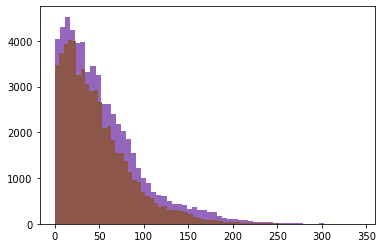

In [293]:
plt.hist(normal_training_euro['abs_error'], bins=60)
plt.hist(normal_training['abs_error'], bins=60)
plt.hist(aggressive_training['abs_error'], bins=60)
plt.hist(normal_training_euro_low_thresh['abs_error'], bins=60)
plt.hist(normal_training_low_thresh['abs_error'], bins=60)
plt.hist(aggressive_training_low_thresh['abs_error'], bins=60)

In [334]:
normal_training.merge()

,site_id,formatted_sci_name,prediction,doy,ripeness_day,abs_error
0,4202683,Rubus,183,183.0,183,0.0
1,4312824,Rubus,183,181.0,183,2.0
2,3522702,Rubus,183,190.0,183,7.0
3,4302743,Rubus,183,193.0,183,10.0
4,3742808,Rubus,183,165.0,183,18.0
...,...,...,...,...,...,...
11,4932369,Pyrus,245,257.0,245,12.0
12,4232769,Pyrus,245,193.0,245,52.0
13,4152782,Pyrus,245,224.0,245,21.0
14,4302888,Pyrus,245,273.0,245,28.0


In [299]:
## Save models!!

normal_training_euro.to_csv("../data/model_training_data/model_predictions/new_models/normal_training_euro.csv")
normal_training.to_csv("../data/model_training_data/model_predictions/new_models/normal_training.csv")
aggressive_training.to_csv("../data/model_training_data/model_predictions/new_models/aggressive_training.csv")
normal_training_euro_low_thresh.to_csv("../data/model_training_data/model_predictions/new_models/normal_training_euro_low_thresh.csv")
normal_training_low_thresh.to_csv("../data/model_training_data/model_predictions/new_models/normal_training_low_thresh.csv")
aggressive_training_low_thresh.to_csv("../data/model_training_data/model_predictions/new_models/aggressive_training_low_thresh.csv")


## Exploratory Hypothesis Testing

In [336]:
## Testing hypothesis that there is more uncertainty with subtropic / tropic environments. 
## Using normal training as a base. 


normal_preds_with_lat_long = normal_training.merge(filtered_plants[['site_id', 'latitude', 'lon_360']].drop_duplicates(), 
                                                  on = 'site_id')


In [337]:
normal_preds_with_lat_long

,site_id,formatted_sci_name,prediction,doy,ripeness_day,abs_error,latitude,lon_360
0,4202683,Rubus,183,183.0,183,0.0,42.000443,268.349632
1,4202683,Rubus,183,183.0,183,0.0,42.012331,268.334416
2,4202683,Morus,183,181.0,183,2.0,42.000443,268.349632
3,4202683,Morus,183,181.0,183,2.0,42.012331,268.334416
4,4312824,Rubus,183,181.0,183,2.0,43.123822,282.422069
...,...,...,...,...,...,...,...,...
7505,4932369,Pyrus,245,257.0,245,12.0,49.255280,236.923103
7506,4932369,Pyrus,245,257.0,245,12.0,49.289902,236.867103
7507,4932369,Pyrus,245,257.0,245,12.0,49.274888,236.874166
7508,4932369,Pyrus,245,257.0,245,12.0,49.267388,236.929277


In [338]:
normal_preds_with_lat_long.to_csv('../data/model_training_data/model_predictions/new_models/normal_training_with_coords.csv')

In [323]:
print("Low Latitude (<35 N) Prediction Error Metrics")
score_model(normal_preds_with_lat_long.query('latitude < 35'))

Low Latitude (<35 N) Prediction Error Metrics
Number of Species: 17
Error metrics:
MAE: 62.42072213500785
RMSE: 86.33002282777568
Median Absolute Error: 45.0
Median portion (median error = 45.0)
0.4411302982731554
SD portion (SD = 59.636618696807595)
0.6200941915227629
Month threshold:
0.434850863422292
2 * SD portion (2SD = 119.27323739361519)
0.8178963893249608


(array([270.,  11., 114.,  98.,   3.,  25.,  28.,  17.,   9.,  62.]),
 array([  2. ,  21.9,  41.8,  61.7,  81.6, 101.5, 121.4, 141.3, 161.2,
        181.1, 201. ]),
 <BarContainer object of 10 artists>)

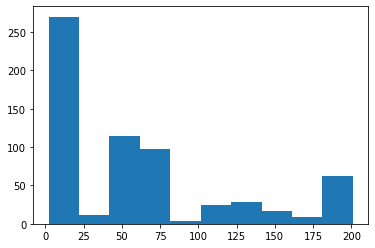

In [320]:
plt.hist(normal_preds_with_lat_long.query('latitude < 35')['abs_error'])